In [20]:
import os
import pandas as pd
import numpy as np
import chardet
import numpy as np
import scipy.stats
import warnings
from scipy.constants import R
from scipy import integrate
from tqdm.auto import tqdm
import plotly.graph_objects as go
import re

# Указываем строку, с которой начинается чтение данных
SRART_ROW = 36  # Нумерация с нуля, поэтому 36 строка в файле - это индекс 35

# Указываем название элемента, с которым хотим работать
ELEMENT = 'Dy'

# Какие скорости нагрева представленны в экспериментальных данных и в каком порядке
# в градус/минута
heating_rates = ['3', '10', '5']

# Указываем названия колонок
column_names = ['temperature'] + heating_rates

# Указываем путь к папке
folder_path = "TGA"

# Получаем все файлы в указанной папке
file_list = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Проверяем, есть ли файлы в списке
if not file_list:
    raise Exception("No files found in the specified directory.")
    
# Выбираем первый файл из списка
tga_file = [file for file in file_list if file.startswith(ELEMENT)]


# Определяем кодировку файла
with open(os.path.join(folder_path, tga_file[0]), 'rb') as f:
    result = chardet.detect(f.read())
file_encoding = result['encoding']

# Считывание данных из CSV файла
df = pd.read_csv(
    os.path.join(folder_path, tga_file[0]),
    skiprows=SRART_ROW,
    names=column_names,
    delimiter=';',
    decimal=',',
    encoding=file_encoding,
    dtype=str  # Прочитать все данные как строки
)

# Замена запятых на точки и преобразование в числа
df = df.apply(lambda x: pd.to_numeric(x.str.replace(',', '.'), errors='coerce'))

# Удаление строк с NaN значениями
df.dropna(inplace=True)

# Устанавливаем колонку 'temperature' в качестве индекса
df.set_index('temperature', inplace=True)

# Сортировка столбцов DataFrame по heating_rates
heating_rates.sort(key=int)  # сортировка элементов списка как целых чисел
df = df[heating_rates]  # переупорядочивание столбцов DataFrame

# Вывод первых пяти строк данных
df.head()

,3,5,10
temperature,,,
31.63192,99.99894,100.07588,99.96317
32.58683,99.99902,100.04476,99.97090
33.54175,100.00064,100.03758,99.97650
34.49666,100.00060,100.03165,99.98113
35.45158,99.99498,100.03084,99.97782


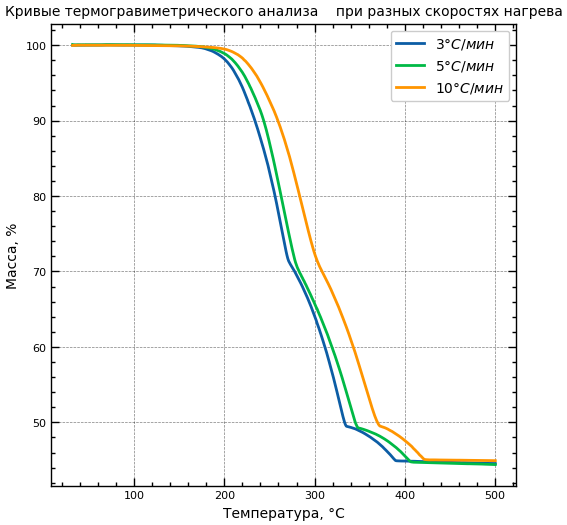

In [21]:
import matplotlib.pyplot as plt
plt.style.use(['science', 'no-latex', 'notebook', 'grid'])

# задаём константы для графиков
BIG_SIZE = 12
MEDIUM_SIZE = 10
SMALL_SIZE = 8

# Создаём фигуру 
fig, axes = plt.subplots(figsize=(6, 6))

axes.plot(df.index, df['3'], label=r'$3°C/мин$')
axes.plot(df.index, df['5'], label=r'$5°C/мин$')
axes.plot(df.index, df['10'], label=r'$10°C/мин$')

# Добавляем подписи на оси
axes.set_xlabel('Температура, °С', fontsize=MEDIUM_SIZE)
axes.set_ylabel('Масса, %', fontsize=MEDIUM_SIZE)
# Добавляем заголовок
axes.set_title('Кривые термогравиметрического анализа\
    при разных скоростях нагрева', 
               fontsize=MEDIUM_SIZE)
# Настраиваем размер легенды и подписей осей
axes.legend(loc='upper right', fontsize=MEDIUM_SIZE)
axes.tick_params(axis='both', which='both', labelsize=SMALL_SIZE)

plt.show()

Кинетику твердофазных реакций можно изучать с помощью термических аналитических методов путем измерения свойств образца при нагреве или при постоянной температуре. Если реакция связана с потерей массы, то масса отслеживается на протяжении реакции, и кинетика обычно изучается с помощью термогравиметрии (ТГА). Тепловой эффект (выделяющийся или поглощаемый) - это еще одно измеряемое свойство, которое используется для кинетической оценки с использованием дифференциальной сканирующей калориметрии (ДСК) или дифференциального термического анализа (ДТА). Данные о потере массы или потоке тепла преобразуются в нормализованную форму, называемую степенью превращения ($\alpha$). Степень превращения варьирует от 0 до 1 и является мерой прогресса реакции в зависимости от времени или температуры.

Для изотермического термогравиметрического анализа доля превращения в любой момент времени определяется следующим образом:

$$ \alpha = \frac{{m_0 - m_t}}{{m_0 - m_{\infty}}} \tag{1}$$

где:
$ m_0 $ - начальная масса образца,
 $ m_t $ - масса образца в момент времени $ t $, 
 $ m_{\infty} $ - конечная масса образца.


In [22]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=df.index, y=df['3'], name=r'$3°C/мин$'))
fig.add_trace(go.Scatter(x=df.index, y=df['5'], name=r'$5°C/мин$'))
fig.add_trace(go.Scatter(x=df.index, y=df['10'], name=r'$10°C/мин$'))

fig.update_layout(
xaxis=dict(title='Температура, °С'),
yaxis=dict(title='Масса, %'),
title=dict(text='Кривые термогравиметрического анализа\
    при разных скоростях нагрева')
)

fig.update_layout(
legend=dict(
x=1,
y=1,
traceorder="normal",
font=dict(size=10)
),
xaxis_tickfont=dict(size=8),
yaxis_tickfont=dict(size=8)
)

fig.show()

Находим температуры при которых заканчиваются одни реакции и начинаются другие

,start,peak_1,peak_2,peak_3,end
3,181.55357,271.31558,335.3,390.67996,415.50775
5,189.19289,277.99999,347.7,406.91351,431.74130
10,204.47153,299.96303,372.5,422.19215,447.01994


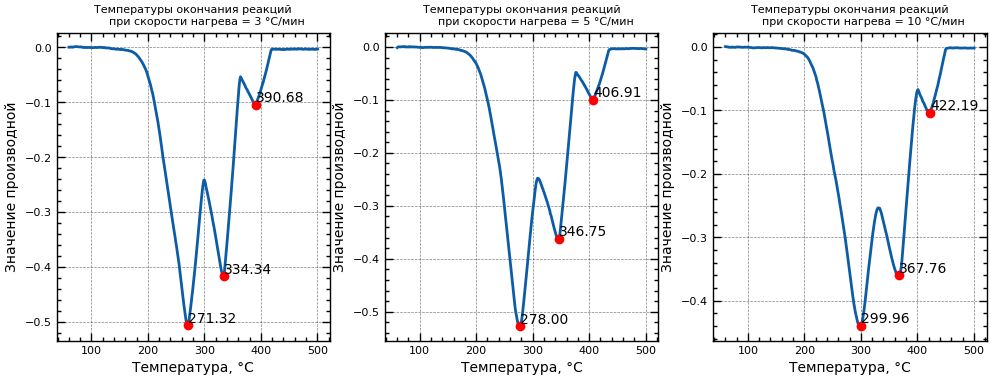

In [23]:
# Определяем значение отсекающее хвосты экспериментов
DIFF_PEAK_CONST = -0.015

# Определение размера окна для сглаживания
window_size = 30

def find_peaks(df):
    positive_mask = df > 0
    positive_after_negative_mask = (
        positive_mask & (~positive_mask.shift(1, fill_value=True)))
    return df[positive_after_negative_mask]

# Инициализация датафрейма с границами начала и конца реакций
peaks_df = pd.DataFrame()

fig, axes = plt.subplots(ncols=3, figsize=(12, 4))

for idx, heating_rate in enumerate(heating_rates):
    # Сглаживание данных с использованием скользящего среднего
    smoothed_df = df[heating_rate].rolling(window_size).mean()

    # Расчет дифференциала (первой производной) для сглаженных данных
    diff_df = smoothed_df.diff()   

    # Находим температуры при которых реакции начинаются и заканчиваются
    t_start = diff_df[diff_df < DIFF_PEAK_CONST].index.min()
    t_end = diff_df[diff_df < DIFF_PEAK_CONST].index.max()

    # Находим температуры пиков по второй производной
    peaks = find_peaks(
        diff_df[(diff_df.index > t_start) & (diff_df.index < t_end)].diff())

    # Обновляем столбцы в датафрейме для каждого heating_rate и заполняем NaN
    columns = ['start'] + [f'peak_{i+1}' for i in range(len(peaks))] + ['end']
    for column in columns:
        if column not in peaks_df.columns:
            peaks_df[column] = np.nan

    peaks_df.at[heating_rate, 'start'] = t_start
    peaks_df.at[heating_rate, 'end'] = t_end
    for i, peak in enumerate(peaks.index):
        peaks_df.at[heating_rate, f'peak_{i+1}'] = peak

    axes[idx].plot(df.index, diff_df)

    # Добавляем заголовок
    axes[idx].set_title(f'Температуры окончания реакций\n\
        при скорости нагрева = {heating_rate} °C/мин', fontsize=SMALL_SIZE)

    # Добавляем подписи на оси
    axes[idx].set_xlabel('Температура, °С', fontsize=MEDIUM_SIZE)
    axes[idx].set_ylabel('Значение производной', fontsize=MEDIUM_SIZE)

    # Настраиваем размер легенды и подписей осей
    axes[idx].tick_params(axis='both', which='both', labelsize=SMALL_SIZE)

    # Выделяем и подписываем точки на графике
    for index in peaks.index:
        peak_value = diff_df[index]
        axes[idx].plot(index, peak_value, 'ro')
        axes[idx].text(
            index, 
            peak_value, 
            f'{index:.2f}', 
            fontsize=10, 
            ha='left', 
            va='bottom')

peaks_df['peak_2']['3'] = 335.3
peaks_df['peak_2']['5'] = 347.7
peaks_df['peak_2']['10'] = 372.5

peaks_df

Разделяем поле температур на области реакций

In [24]:
# Цикл по скоростям нагрева
for rate in heating_rates:
    # Получаем значения пиков для текущей скорости нагрева
    peaks = peaks_df.loc[rate]

    # Создаем список всех пиков, включая старт и финиш
    peaks_list = (
        [peaks['start']] 
         + [peaks[col] for col in peaks_df.columns if 'peak' in col] 
         + [peaks['end']])

    # Функция для определения реакции
    def get_reaction(temp):
        for i in range(len(peaks_list) - 1):
            if peaks_list[i] <= temp < peaks_list[i + 1]:
                return f'reaction_{i}'
        return 'no_reaction'

    # Применяем функцию к индексу df и создаем новый столбец
    df['reactions_' + str(rate)] = df.index.to_series().apply(get_reaction)

Находим степень конверсии для каждой реакции в каждом значении температуры

In [25]:
for rate in heating_rates:
    reaction_col = f'reactions_{rate}'
    heating_rate_col = f'{rate}'
    conversion_col = f'conversion_{rate}'

    # Получаем начальные и конечные значения температуры для каждой реакции
    df_temp = df[df[reaction_col] != 'no_reaction']
    min_max_mass = df_temp.groupby(reaction_col)[heating_rate_col]\
        .agg(['min', 'max'])

    # Создаем новый столбец с нулевыми значениями
    df[conversion_col] = 0

    # Расчет степени превращения для каждой реакции
    for reaction in min_max_mass.index:
        reaction_mask = df[reaction_col] == reaction
        _min = min_max_mass.loc[reaction, 'min']
        _max = min_max_mass.loc[reaction, 'max']
        df.loc[reaction_mask, conversion_col] = (_max - df.loc[reaction_mask, heating_rate_col]) / (_max - _min)


,3,5,10,reactions_3,reactions_5,reactions_10,conversion_3,conversion_5,conversion_10
temperature,,,,,,,,,
31.63192,99.99894,100.07588,99.96317,no_reaction,no_reaction,no_reaction,0.0,0.0,0.0
32.58683,99.99902,100.04476,99.97090,no_reaction,no_reaction,no_reaction,0.0,0.0,0.0
33.54175,100.00064,100.03758,99.97650,no_reaction,no_reaction,no_reaction,0.0,0.0,0.0
34.49666,100.00060,100.03165,99.98113,no_reaction,no_reaction,no_reaction,0.0,0.0,0.0
35.45158,99.99498,100.03084,99.97782,no_reaction,no_reaction,no_reaction,0.0,0.0,0.0


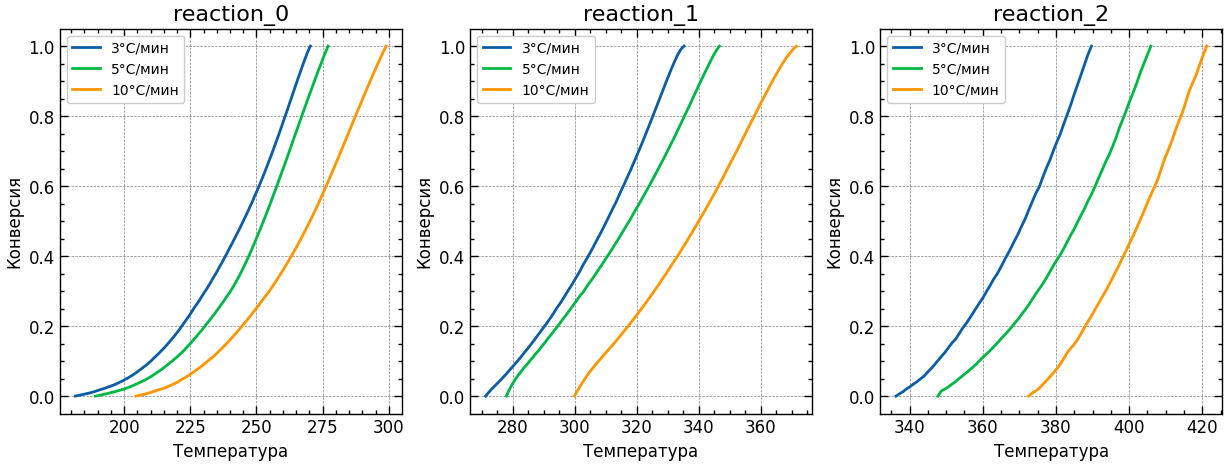

In [26]:
# Получаем уникальные реакции, исключая 'no_reaction', 
# из всех столбцов reactions
all_reactions = pd.unique(
    df[[f'reactions_{rate}' for rate in heating_rates]].values.ravel())
all_reactions = all_reactions[all_reactions != 'no_reaction']

# Отбрасываем последнюю реакцию
all_reactions = all_reactions[:-1]

# Создайте фигуру с несколькими подграфиками
fig, axs = plt.subplots(1, len(all_reactions), 
                        figsize=(5 * len(all_reactions), 5))

# Если есть только одна реакция, axs не будет списком, 
# поэтому обработаем этот случай
if len(all_reactions) == 1:
    axs = [axs]

# Строим графики для каждой реакции
for ax, reaction in zip(axs, all_reactions):
    for rate in heating_rates:
        conversion_col = f'conversion_{rate}'
        reactions_col = f'reactions_{rate}'
        mask = df[reactions_col] == reaction
        if mask.any():
            ax.plot(df.loc[mask].index, df.loc[mask, conversion_col], 
                    label=f'{rate}°С/мин')
    ax.set_title(reaction)
    ax.set_xlabel('Температура', fontsize=BIG_SIZE)
    ax.set_ylabel('Конверсия', fontsize=BIG_SIZE)
    # Настраиваем размер легенды и подписей осей
    ax.legend(loc='upper left', fontsize=MEDIUM_SIZE)
    ax.tick_params(axis='both', which='both', labelsize=BIG_SIZE)

df.head()

$$ Прямой~дифференциальный~метод$$
Этот метод использует скорость нагрева, обычно линейную ($\beta$), для повышения температуры. Линейная программа нагрева следует формуле:

$$ T = T_0 + \beta t \tag{2}$$

где $T_0$ - начальная температура, $\beta$ - линейная скорость нагрева (К/мин), и $T$ - температура в момент времени $t$. 

Следующее соотношение можно определить для неизотермических экспериментов:

$$ \frac{{d\alpha}}{{dT}} = \frac{{d\alpha}}{{dt}} \cdot \frac{{dt}}{{dT}} \tag{3}$$

где $\frac{{d\alpha}}{{dT}}$ - неизотермическая скорость реакции; $\frac{{d\alpha}}{{dt}}$ - изотермическая скорость реакции, а $\frac{{dt}}{{dT}}$ - скорость нагрева ($\beta$). 

Дифференциальный закон скорости для реакции первого порядка может быть записан в виде:$$ Скорость~реакции~=~\frac{d[A]}{dt}=-k[A]\tag{4}$$ 
Здесь скорость реакции (изменение концентрации $[A]$ в единицу времени) пропорциональна концентрации реагента $[A]$. Отрицательный знак указывает на то, что концентрация $[A]$ с течением времени уменьшается.


Переформулировав уравнение (4), заменим концентрацию реагента $[A]$ на степень превращения $\alpha$: $$ Скорость~реакции~=~\frac{d\alpha}{dt} = k\left(1 - \alpha\right) \tag{5}$$

Обобщим уравнение (5), введя функцию $f(\alpha)$, которая отражает специфический характер реакции.$$\frac{d\alpha}{dt} = kf(\alpha)\tag{6}$$ 

Уравнение Аррениуса, которое описывает температурную зависимость константы скорости реакции выглядит следующим образом:$$k = A e^{-\frac{E_a}{RT}} \tag{7}$$
Путем подстановки уравнения Аррениуса (7) в обобщенный дифференциальный закон скорости (6) получаем:$$\frac{d\alpha}{dt} = A e^{-\frac{E_a}{RT}}f(\alpha) \tag{8}$$
Подставляя уравнение (8) в уравнение (3), получим дифференциальную форму неизотермического закона скорости:

$$ \frac{{d\alpha}}{{dT}} = \frac{A}{\beta}  e^{-\frac{{E_a}}{{RT}}}  f(\alpha) \tag{9}$$
Откуда: $$\ln\left(\frac{{da}}{{dT}}\cdot\frac{{1}}{{f(a)}}\right) = \ln \frac{{A}}{{\beta}} - \frac{{E_a}}{{RT}} \tag{10}$$

Построение графика левой части (включая модель $f(\alpha)$) относительно $\frac{1}{T}$ позволяет получить энергию активации ($E_a$) и предэкспоненциальный множитель ($A$) из наклона и пересечения с осью $y$ соответственно. Обычно выбирается модель, которая обеспечивает наилучшую линейную аппроксимацию.


In [27]:
# Загружаем данные по кинетическим моделям
models_df = pd.read_csv('nucleation_models.csv')
# models_df.loc[models_df['Model'] == 'Zero-order (F0/R1)', 'Differential Form'] = 'np.full_like(a, 1)'
models_df

,Model,Differential Form,Integral Form
0,Power law (P2),2*a**(1/2),a**(1/2)
1,Power law (P3),3*a**(2/3),a**(1/3)
2,Power law (P4),4*a**(3/4),a**(1/4)
3,Avarami-Erofe’ev (A2),2*(1 - a)*(-np.log(1 - a))**(1/2),(-np.log(1 - a))**(1/2)
4,Avarami-Erofe’ev (A3),3*(1 - a)*(-np.log(1 - a))**(2/3),(-np.log(1 - a))**(1/3)
5,Avarami-Erofe’ev (A4),4*(1 - a)*(-np.log(1 - a))**(3/4),(-np.log(1 - a))**(1/4)
6,Prout–Tompkins (B1),a*(1 - a)*np.log(a/(1 - a)),np.log(a/(1 - a))
7,Contracting area (R2),2*(1 - a)**(1/2),1-(1 - a)**(1/2)
8,Contracting volume (R3),3*(1 - a)**(2/3),1-(1 - a)**(1/3)
9,1-D diffusion (D1),1/2*a,a**2


In [28]:
warnings.filterwarnings('ignore')  # Отключение предупреждений

# Создание нового DataFrame для хранения результатов. 
# Он будет содержать информацию о модели, уравнении, коэффициентах корреляции, активационной энергии (Ea) и коэффициенте частоты (A)
direct_diff = pd.DataFrame(columns=['Model', 'beta', 'Equation', 'R_corr', 'Ea', 'A', 'R_sq'])

# Из DataFrame забираем формулы моделей и имена моделей
f_a = models_df['Differential Form'].to_list()
f_names = models_df['Model'].to_list()

# Проходимся по каждой модели для обработки данных
for i, model in enumerate(f_a):
    # Проходимся по каждой скорости нагрева
    for beta in heating_rates:        
        # Создаем запрос для получения данных для каждой реакции
        query = f"reactions_{beta} == 'reaction_0'"
        
        # Получаем температуру и степень превращения для каждого значения beta
        temperature = df.query(query)[beta].index[1:-2] # убираем значения конверсии = 0 и 1, так как они не применимы для нашего анализа
        conversion = df.query(query)[f'conversion_{beta}'].values[1:-2] # убираем значения конверсии = 0 и 1, так как они не применимы для нашего анализа       
        
        # Вычисляем производную степени превращения по температуре. Это является частью общего уравнения модели
        da_dT = np.gradient(conversion, temperature)
        
        # Выбираем модель и вычисляем значение f(a) для каждого значения степени превращения
        def model_func(a):
            try:
                return eval(model)
            except ZeroDivisionError:
                return np.inf  # В случае деления на ноль, возвращаем бесконечность, чтобы избежать ошибки
        
        f_a_val = model_func(conversion)
        
        # Вычисляем левую часть уравнения. Это является частью общего уравнения модели
        try:
            lhs = np.log(da_dT / f_a_val)
        except ZeroDivisionError:
            lhs = np.inf

        # Удаляем бесконечные значения и NaN из данных, так как они могут искажать результаты регрессии и корреляции
        mask = np.isfinite(lhs) & np.isfinite(1/temperature)
        temperature_clean = (1/temperature)[mask]
        lhs_clean = lhs[mask]

        # Выполняем линейную регрессию для нахождения зависимости между 1/T и ln(da/dT / f(a))
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(temperature_clean, lhs_clean)
        
        # Рассчитываем Ea и A из угла наклона и пересечения с осью Y. 
        Ea = -slope * R
        A = np.exp(intercept) * int(beta)
        
        # Вычисляем коэффициенты корреляции
        # Коэффициент детерминации (R^2) является квадратом коэффициента корреляции Пирсона (r_value). 
        # Он отображает долю вариации зависимой переменной, объясняемую моделью        
        r_squared = r_value**2  
        # Коэффициент корреляции Спирмена оценивает монотонную зависимость 
        # между двумя переменными, полагаясь на ранги, а не на сами значения
        spearman_corr, _ = scipy.stats.spearmanr(temperature_clean, lhs_clean)
        # Коэффициент корреляции Кендалла также оценивает монотонную зависимость, 
        # но фокусируется на согласованности направления в парах данных
        kendall_corr, _ = scipy.stats.kendalltau(temperature_clean, lhs_clean)
          
        # Добавляем значения в direct_diff
        direct_diff = direct_diff.append({'Model': f_names[i],
                                          'beta': beta,
                                          'Equation': model,                                          
                                          'R_corr': r_value,
                                          'Ea': Ea,
                                          'A': A,
                                          'R_sq': r_squared,
                                          }, ignore_index=True)

warnings.filterwarnings('default')  # Включаем обратно предупреждения

direct_diff.head(15)


,Model,beta,Equation,R_corr,Ea,A,R_sq
0,Power law (P2),3,2*a**(1/2),-0.387969,760.617762,0.049591,0.150520
1,Power law (P2),5,2*a**(1/2),-0.468042,1272.155548,0.107242,0.219063
2,Power law (P2),10,2*a**(1/2),0.228959,-496.961309,0.080924,0.052422
3,Power law (P3),3,3*a**(2/3),0.790525,-3229.541575,0.005206,0.624930
4,Power law (P3),5,3*a**(2/3),0.704174,-3055.702052,0.010170,0.495861
5,Power law (P3),10,3*a**(2/3),0.855011,-4974.315605,0.008234,0.731044
6,Power law (P4),3,4*a**(3/4),0.874165,-5224.621243,0.001549,0.764164
7,Power law (P4),5,4*a**(3/4),0.832633,-5219.630852,0.002877,0.693277
8,Power law (P4),10,4*a**(3/4),0.897571,-7212.992753,0.002412,0.805635
9,Avarami-Erofe’ev (A2),3,2*(1 - a)*(-np.log(1 - a))**(1/2),-0.795796,7924.931176,3.665895,0.633291


In [29]:
# Функция get_data извлекает температуру и степень преобразования из переданного DataFrame
def get_data(df, beta):
    # Запрос используется для получения подмножества данных, 
    # где reactions_beta равно 'reaction_0'
    query = f"reactions_{beta} == 'reaction_0'"
    # Получение индекса температуры для данного запроса, 
    # исключая первый и последний элементы
    temperature = df.query(query)[beta].index[1:-2]
    # Получение значения преобразования для данного запроса, 
    # исключая первый и последний элементы
    conversion = df.query(query)[f'conversion_{beta}'].values[1:-2]
    return temperature, conversion

# Функция calculate_derivative вычисляет 
# производную степени преобразования по температуре
def calculate_derivative(temperature, conversion):
    return np.gradient(conversion, temperature)

# Функция model_func вычисляет значение функции модели
def model_func(model, conversion):
    try:
        # eval используется для выполнения строки кода
        return eval(model, {'a': conversion, 'np': np})
    except ZeroDivisionError:
        return np.inf

# Функция calculate_lhs вычисляет левую часть уравнения для регрессии
def calculate_direct_diff_lhs(da_dT, f_a_val):
    try:
        return np.log(da_dT / f_a_val)
    except ZeroDivisionError:
        return np.inf

# Функция filter_data фильтрует данные, удаляя все нечисловые значения
def filter_data(lhs, temperature):
    mask = np.isfinite(lhs) & np.isfinite(1/temperature)
    return (1/temperature)[mask], lhs[mask]

# Функция perform_regression выполняет линейную регрессию на очищенных данных
def perform_regression(temperature_clean, lhs_clean):
    return scipy.stats.linregress(temperature_clean, lhs_clean)

# Функция calculate_parameters вычисляет параметры модели
def calculate_direct_diif_params(slope, intercept, beta):
    R = 8.314
    Ea = -slope * R
    A = np.exp(intercept) * int(beta)
    return Ea, A

# Функция calculate_correlations вычисляет различные корреляции
def calculate_correlations(temperature_clean, lhs_clean, r_value):
    r_squared = r_value**2
    spearman_corr, _ = scipy.stats.spearmanr(temperature_clean, lhs_clean)
    kendall_corr, _ = scipy.stats.kendalltau(temperature_clean, lhs_clean)
    return r_squared, spearman_corr, kendall_corr

# Главная функция, в которой выполняется весь процесс
def main(df, models_df):
    # Отключение предупреждений
    warnings.filterwarnings('ignore')
    
    # Создание нового DataFrame для хранения результатов
    direct_diff = pd.DataFrame(columns=[
        'Model', 'beta', 'Equation', 'R_corr', 'R_sq', 'R_std', 'Ea', 'A', ])
    # Извлечение данных из DataFrame моделей
    f_a = models_df['Differential Form'].to_list()
    f_names = models_df['Model'].to_list()    

    # Цикл по каждой модели и каждому темпу нагрева
    for i, model in enumerate(f_a):
        for beta in heating_rates:
            # Получение данных для заданной модели и темпа нагрева
            temperature, conversion = get_data(df, beta)
            # Вычисление производной
            da_dT = calculate_derivative(temperature, conversion)
            # Вычисление значения функции модели
            f_a_val = model_func(model, conversion)
            # Вычисление левой части уравнения для регрессии
            lhs = calculate_direct_diff_lhs(da_dT, f_a_val)
            # Фильтрация данных
            temperature_clean, lhs_clean = filter_data(lhs, temperature)
            # Выполнение линейной регрессии
            slope, intercept, r_value, p_value, std_err = perform_regression(temperature_clean, lhs_clean)
            # Вычисление параметров модели
            Ea, A = calculate_direct_diif_params(slope, intercept, beta)            

            # Добавление полученных результатов в DataFrame
            direct_diff = direct_diff.append({'Model': f_names[i],
                                              'beta': beta,
                                              'Equation': model,
                                              'R_corr': r_value,
                                              'R_std': std_err,
                                              'Ea': Ea,
                                              'A': A,
                                              'R_sq': r_value**2,
                                              }, ignore_index=True)

    # Включение обратно предупреждений
    warnings.filterwarnings('default')
    return direct_diff

direct_diff = main(df, models_df)
direct_diff.sort_values(by='R_sq', ascending=False).head(20)

,Model,beta,Equation,R_corr,R_sq,R_std,Ea,A
34,3-D diffusion-Jander eqn.(D3),5,3*(1 - a)**(2/3)/(2*(1-(1-a)**(1/3))),-0.994378,0.988787,67.573714,49491.169001,4.294955e+08
22,Contracting area (R2),5,2*(1 - a)**(1/2),-0.993964,0.987964,27.201350,19221.172856,6.588772e+02
33,3-D diffusion-Jander eqn.(D3),3,3*(1 - a)**(2/3)/(2*(1-(1-a)**(1/3))),-0.992323,0.984705,71.779572,45173.702500,6.204776e+07
31,2-D diffusion (D2),5,-(np.log(1 - a))**(-1),-0.992096,0.984254,72.067004,44438.589552,1.040625e+08
23,Contracting area (R2),10,2*(1 - a)**(1/2),-0.990836,0.981755,31.395507,18662.657275,4.938905e+02
21,Contracting area (R2),3,2*(1 - a)**(1/2),-0.990526,0.981141,30.546560,17281.100266,1.959855e+02
35,3-D diffusion-Jander eqn.(D3),10,3*(1 - a)**(2/3)/(2*(1-(1-a)**(1/3))),-0.989669,0.979444,90.199336,50454.512065,2.477033e+08
30,2-D diffusion (D2),3,-(np.log(1 - a))**(-1),-0.989366,0.978846,75.992965,40545.033186,1.728593e+07
25,Contracting volume (R3),5,3*(1 - a)**(2/3),-0.987738,0.975626,42.308833,20876.585422,1.144435e+03
40,Zero-order (F0/R1),5,1,-0.986090,0.972373,30.807804,14254.935159,7.450758e+01


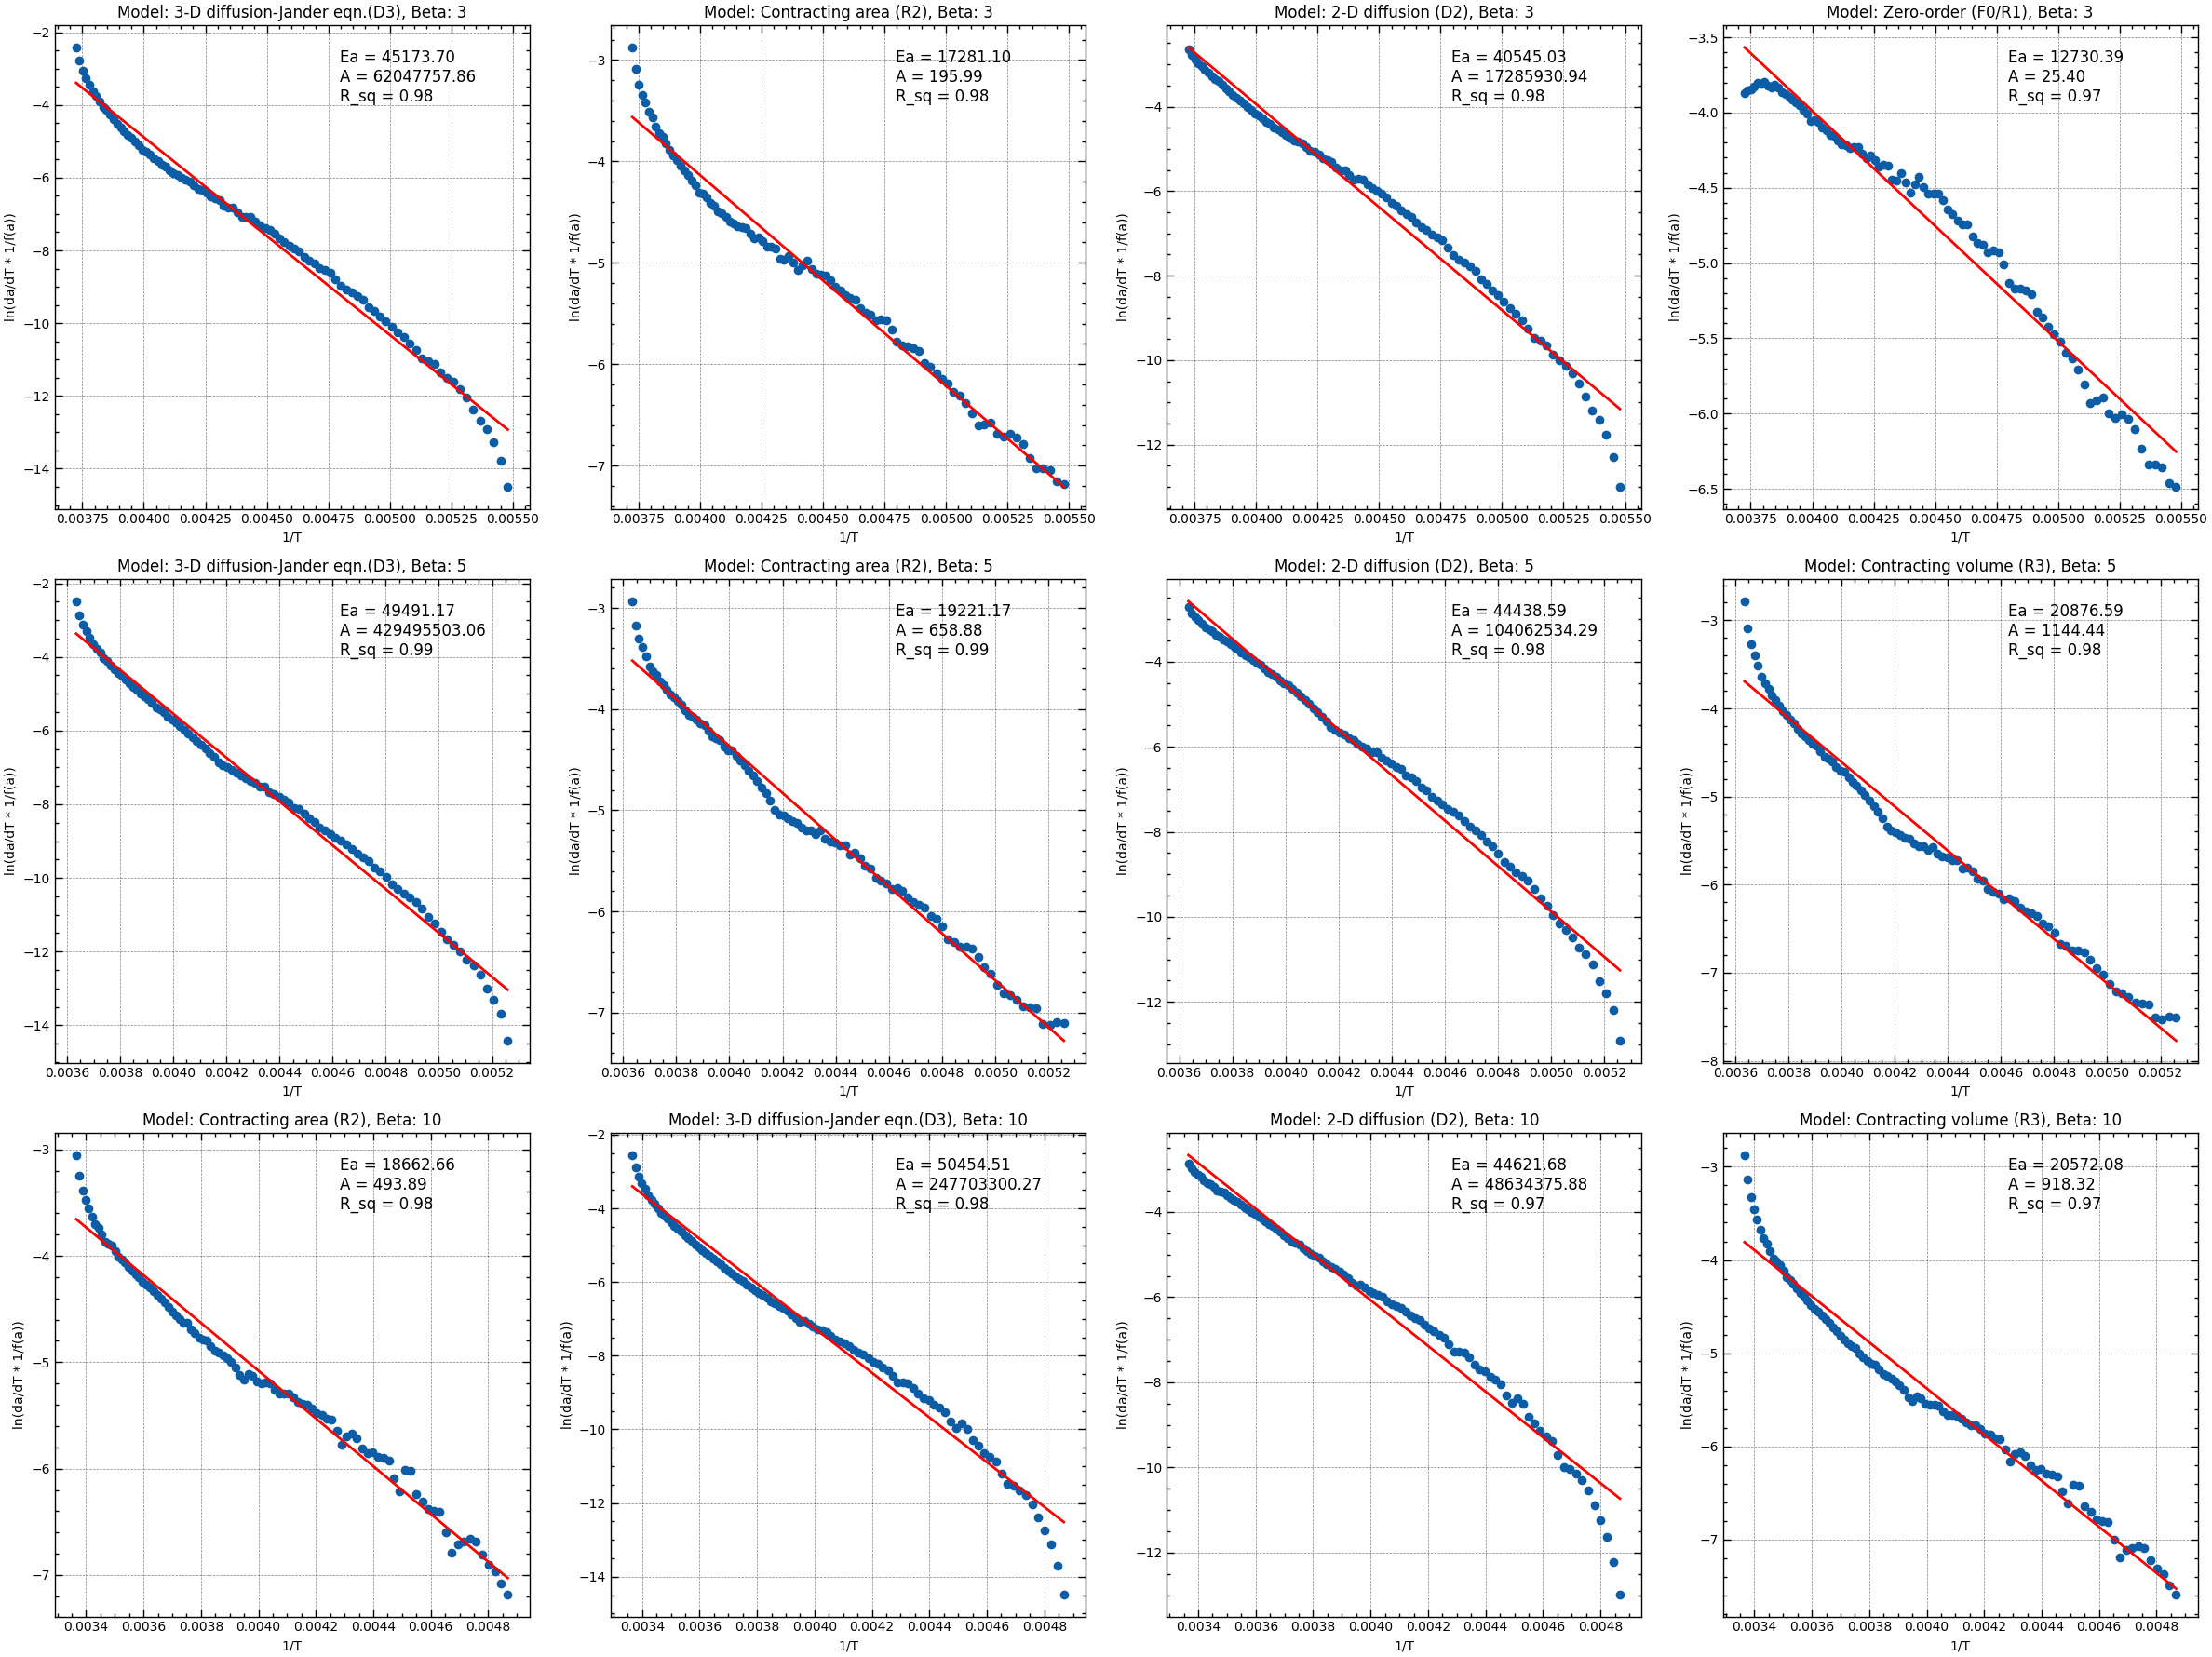

In [30]:
fig, axs = plt.subplots(3, 4, figsize=(24, 18))  # 3 строки, 4 столбца

for j, beta in enumerate(heating_rates):
    # Создаем фильтр для каждого beta
    beta_filter = direct_diff['beta'] == beta
    
    # Применяем фильтр к DataFrame и сортируем его по 'R_sq'
    top_4_models = direct_diff[beta_filter].sort_values('R_sq', ascending=False).head(4)
    
    for i, (idx, row) in enumerate(top_4_models.iterrows()):
        model = row['Equation']
        model_name = row['Model']
        
        temperature, conversion = get_data(df, beta)
        da_dT = calculate_derivative(temperature, conversion)
        f_a_val = model_func(model, conversion)
        lhs = calculate_direct_diff_lhs(da_dT, f_a_val)
        temperature_clean, lhs_clean = filter_data(lhs, temperature)
        
        # Строим график для каждой модели
        axs[j][i].plot(1/temperature, lhs, 'o')
        axs[j][i].set_title(f'Model: {model_name}, Beta: {beta}', fontsize=BIG_SIZE)
        axs[j][i].set_xlabel('1/T', fontsize=MEDIUM_SIZE)
        axs[j][i].set_ylabel('ln(da/dT * 1/f(a))', fontsize=MEDIUM_SIZE)
        
        # Выполняем линейную регрессию и строим прямую линию
        slope, intercept, _, _, _ = perform_regression(temperature_clean, lhs_clean)
        axs[j][i].plot(1/temperature, slope*(1/temperature) + intercept, 'r-')
        
        # Выводим значения Ea, A, R_sq, R_corr, Spearman_corr, Kendall_corr на график
        Ea = row['Ea']
        A = row['A']
        r_sq = row['R_sq']        
        axs[j][i].text(0.60, 0.95, f'Ea = {Ea:.2f}\nA = {A:.2f}\nR_sq = {r_sq:.2f}', transform=axs[j][i].transAxes, fontsize=BIG_SIZE, verticalalignment='top')
        axs[j][i].tick_params(axis='both', which='both', labelsize=MEDIUM_SIZE)

plt.tight_layout()
plt.show()

$$Метод~Фримена~и~Кэрролла$$
Взятие натурального логарифма от дифференциальной формы закона скорости неизотермической реакции (уравнение 9) дает:

$$
\ln \frac{da}{dT} = \ln \frac{A}{\beta} - \frac{Ea}{RT} + \ln f(a) \tag{11}
$$

Если взять приращения переменных в уравнении 11, мы получим:

$$
\Delta \ln \frac{d\alpha}{dT} = \Delta \ln f(\alpha) - \frac{Ea}{R} \Delta \frac{1}{T} \tag{12}
$$

Разделив обе части уравнения на приращение обратной температуры получим:

$$
\frac{\Delta \ln \frac{d\alpha}{dT}}{\Delta \frac{1}{T}} = \frac{\Delta \ln f(\alpha)}{\Delta \frac{1}{T}} - \frac{Ea}{R} \tag{13}
$$

или

$$
\frac{\Delta \ln \frac{d\alpha}{dT}}{\Delta \ln f(\alpha)} = -\frac{Ea}{R} \frac{\Delta \frac{1}{T}}{\Delta \ln f(\alpha)} \tag{14}
$$

Активационная энергия может быть получена путем построения графика левой части уравнений (13) против $\Delta \ln f(\alpha) / \Delta \frac{1}{T}$ в точке пересечения с осью ординат. В случае уравнения (14) левая часть против $\Delta \frac{1}{T} / \Delta \ln f(\alpha)$ с нахождением угла наклона прямой.


In [31]:
def main_friedman_carroll(df, models_df):
    # Отключение предупреждений
    warnings.filterwarnings('ignore')

    # Создание нового DataFrame для хранения результатов
    result_df = pd.DataFrame(columns=[
        'Model', 'beta', 'Equation', 'R_corr_13', 'R_corr_14', 
        'R_std_13', 'R_std_14', 'R_sq_13', 'R_sq_14', 'Ea_13', 'Ea_14'])

    # Извлечение данных из DataFrame моделей
    f_a = models_df['Differential Form'].to_list()
    f_names = models_df['Model'].to_list()  

    # Цикл по каждой модели и каждому темпу нагрева
    for i, model in enumerate(f_a):
        for beta in heating_rates:
            try:
                # Получение данных для заданной модели и темпа нагрева
                temperature, conversion = get_data(df, beta)

                # Создание нового DataFrame для хранения производных и логарифмов
                data = pd.DataFrame(index=temperature)
                data['conversion'] = conversion
                data['log_da_dT'] = np.log(np.gradient(conversion, temperature))
                data['f_a_val'] = model_func(model, conversion)
                data['log_f_a_val'] = np.log(data['f_a_val'])
                data['inv_T'] = 1 / temperature 

                # Вычисление дельты для всех столбцов
                data = data.diff()

                # Вычисление левой части по уравнению 13
                data['lhs_13'] = data['log_da_dT'] / data['inv_T']
                
                # Вычисление левой части по уравнению 14
                data['lhs_14'] = data['log_da_dT'] / data['log_f_a_val']

                # Исключение NaN значений
                data = data.dropna()

                # Находим пересечение с осью ординат прямой для ур. 13
                _, intercept_13, r_value_13, _, std_err_13 = perform_regression(
                    data['lhs_13'], 
                    data['log_f_a_val'] / data['inv_T'])

                # Вычисляем Ea_13
                Ea_13 = intercept_13 * -R                
                
                # Находим угол наклона прямой для ур. 14
                slope_14, _, r_value_14, _, std_err_14 = perform_regression(
                    data['lhs_14'], 
                    data['inv_T'] / data['log_f_a_val'])
                
                # Вычисляем Ea_14
                Ea_14 = slope_14 * -R                
                
                # Добавление полученных результатов в DataFrame
                result_df = result_df.append({'Model': f_names[i],
                                              'beta': beta,
                                              'Equation': model,
                                              'R_corr_13': r_value_13,
                                              'R_corr_14': r_value_14,
                                              'R_std_13': std_err_13,
                                              'R_std_14': std_err_14,
                                              'Ea_13': Ea_13,
                                              'Ea_14': Ea_14,
                                              'R_sq_13': r_value_13**2,
                                              'R_sq_14': r_value_14**2,
                                              }, ignore_index=True)
            except TypeError:
                print(f"TypeError occurred for model: {f_names[i]}")

    # Включение обратно предупреждений
    warnings.filterwarnings('default')
    return result_df

friedman_carroll = main_friedman_carroll(df, models_df)
friedman_carroll.sort_values(by='R_sq_13', ascending=False).head(15)


,Model,beta,Equation,R_corr_13,R_corr_14,R_std_13,R_std_14,R_sq_13,R_sq_14,Ea_13,Ea_14
20,Prout–Tompkins (B1),10,a*(1 - a)*np.log(a/(1 - a)),0.532203,-0.547613,3.961181,0.000093,0.283240,0.299880,75310.706833,0.002574
18,Prout–Tompkins (B1),3,a*(1 - a)*np.log(a/(1 - a)),0.531569,-0.862627,2.185240,0.000071,0.282566,0.744126,15211.224573,0.004747
17,Avarami-Erofe’ev (A4),10,4*(1 - a)*(-np.log(1 - a))**(3/4),0.351967,-0.984723,0.194828,0.000009,0.123880,0.969680,-3239.513007,0.004109
14,Avarami-Erofe’ev (A3),10,3*(1 - a)*(-np.log(1 - a))**(2/3),0.350065,-0.941479,0.192328,0.000020,0.122546,0.886383,-6439.763132,0.004509
49,Third-order (F3),5,(1 - a)**3,0.343455,-0.520669,0.880863,0.000030,0.117961,0.271097,-102550.844920,0.001438
25,Contracting volume (R3),5,3*(1 - a)**(2/3),0.343455,-0.520669,0.195747,0.000030,0.117961,0.271097,-22789.076649,0.001438
46,Second-order (F2),5,(1 - a)**2,0.343455,-0.520669,0.587242,0.000030,0.117961,0.271097,-68367.229947,0.001438
43,First-order (F1),5,(1 - a),0.343455,-0.520669,0.293621,0.000030,0.117961,0.271097,-34183.614973,0.001438
22,Contracting area (R2),5,2*(1 - a)**(1/2),0.343455,-0.520669,0.146810,0.000030,0.117961,0.271097,-17091.807487,0.001438
11,Avarami-Erofe’ev (A2),10,2*(1 - a)*(-np.log(1 - a))**(1/2),0.343215,-0.610879,0.189115,0.000073,0.117797,0.373173,-12840.263383,0.004519


$$ Интегральные~методы$$

Интегрирование дифференциального неизотермического уравнения скорости приводит к интегральной форме неизотермического уравнения скорости:

$$ g(a) = \frac{A}{\beta} \int_{0}^{T} e^{\frac{-Ea}{RT}} dT \tag{15} $$

Этот интеграл называется температурным интегралом и не имеет аналитического решения. Чтобы преобразовать вышеупомянутый интеграл в более общую форму, которую можно найти в математических справочниках, переменную интегрирования можно переопределить как,

$$x = \frac{Ea}{RT}$$

и температурный интеграл становится:

$$ g(a) = \frac{AEa}{\beta R} \int_{x}^{\infty} \frac{e^{-x}}{x^2} dx \tag{16} $$

Если $p(x) = \int_{x}^{\infty} \frac{e^{-x}}{x^2} dx$, тогда уравнение 16 может быть записано как:

$$g(a) = \frac{AE_a}{\beta R} p(x) \tag{17}$$

где $p(x)$ - экспоненциальный интеграл. Основные подходы, используемые для оценки температурного/экспоненциального интеграла, включают:

1. Вычисление значений $p(x)$ численно.
2. Преобразование $p(x)$ в приближенную форму, которую можно интегрировать.
3. Аппроксимация $p(x)$ рядом разложения.


Два наиболее используемых ряда для аппроксимации температурного интеграла:

I. Асимптотическое разложение в ряд

$$p(x) = \frac{e^{-x}}{x^2} \left(1 - \frac{1}{2!x} + \frac{1}{3!x^2} - \frac{1}{4!x^3} + \ldots + (-1)^n \frac{n}{(n+1)!x^n} + \ldots \right)$$

II. Разложение в ряд Шлёмилха

$$p(x) = \frac{e^{-x}}{x(x+1)} \left(1 - \frac{1}{(x+2)} + \frac{2}{(x+2)(x+3)} - \frac{4}{(x+2)(x+3)(x+4)} + \ldots \right)$$

Многие приближения были предложены для температурного интеграла, два из которых будут рассмотрены - это приближения Дойла и Сенума-Янга. Они являются одними из наиболее распространенных приближений температурного/экспоненциального интеграла, так как каждое из них является основой для конкретного метода кинетического расчета.

$$ Приближение~Дойля $$ 

Приближение экспоненциального интеграла ($p(x)$) Дойлем основано на наблюдении, что $\log p(x)$ довольно линейно относительно $x$ в небольшом диапазоне значений $x$. Дойль приближал значения $p(x)$, используя первые три члена ряда Шлёмилха и наблюдаемое линейное соотношение для $x = 28–50$, чтобы получить по регрессии следующее приближение температурного интеграла:

$$\log p(x) = -2.315 - 0.4567x \tag{18}$$

Определено, что качество этой линейной зависимости довольно высоко с $R^2 = 0.99999$.

$$Приближение~Сенума-Янга$$ 

Сенум и Янг разработали точное нелинейное приближение температурного интеграла. Если переменные в Ур. 16 преобразуются так, что $x = zy$, то интеграл становится,

$$g(a) = \frac{AEa}{Rz} \int_{1}^{\infty} \frac{e^{zy}}{y^2} dy$$


Которое можно записать как,

$$g(a) = \frac{AEa}{Rz} E_2(z) \tag{19}$$

$E_2(z)$ или, в общем случае, $E_v(z)$ (где $v$ - целое число) - это хорошо известный интеграл для $z > 0$, заданный следующей непрерывной дробью:

$$\frac{E_v(z)}{z} = \frac{e^{-z}}{z} \cdot \cfrac{e^z}{z + \cfrac{v}{1 + \cfrac{1}{z + \cfrac{v+1}{1 + \cfrac{2}{z + \ddots}}}}} $$

Усечение числа членов в вышеприведенной непрерывной дроби дает первое (один член), второе (два члена), третье (три члена) и четвертое (четыре члена) рациональные приближения, известные как приближения Сенума-Янга.

$$ 1.~~p(x) = \frac{e^x}{x} - \frac{1}{x + 2} $$
$$ 2.~~p(x) = \frac{e^x}{x} - \frac{x + 4}{x^2 + 6x + 6} $$
$$ 3.~~p(x) = \frac{e^x}{x} - \frac{x^2 + 10x + 18}{x^3 + 12x^2 + 36x + 24} $$
$$ 4.~~p(x) = \frac{e^x}{x} - \frac{x^3 + 18x^2 + 86x + 96}{x^4 + 20x^3 + 120x^2 + 240x + 120} $$


$$ Метод~Коутса–Редферна $$

Этот метод использует интегральную форму неизотермического закона скорости (уравнение 17). Коутс и Редферн использовали асимптотическое разложение ряда для приближения температурного интеграла (p(x)), получив:

$$\ln\left(\frac{g(a)}{T^2}\right) = \ln\left(\frac{AR}{\beta E_a} \left[1 - \frac{2RT_{\text{exp}}}{E_a}\right]\right) + \frac{E_a}{RT} \tag{20}$$



где $T_{\text{exp}}$ - средняя экспериментальная температура. Построение графика левой части (включая модель, $g(a)$) уравнения 20 в отношении $1/T$ дает энергию активации ($E_a$) и частотный фактор (A) от угла наклона прямой и пересечения с осью ординат, соответственно. Выбирается модель, которая дает наилучшую линейную аппроксимацию. 

In [32]:
# Эта функция вычисляет левую часть уравнения Coats-Redfern
def calculate_coats_redfern_lhs(g_a_val, T):
    try:
        # Вычисляем значение левой части уравнения Coats-Redfern
        # Если возникает ошибка деления на ноль, возвращаем бесконечность
        return np.log(g_a_val / (T**2))
    except ZeroDivisionError:
        return np.inf

# Фильтрация данных, удаляя все нечисловые значения
def filter_data(lhs, inverse_T):
    # Создаем маску для значений, которые являются числами в обоих массивах
    mask = np.isfinite(lhs) & np.isfinite(inverse_T)
    # Применяем маску к обоим массивам и возвращаем результат
    return inverse_T[mask], lhs[mask]

# Вычисление параметров модели
def calculate_coats_redfern_params(slope, intercept, beta):    
    # Вычисляем энергию активации на основе угла наклона прямой регрессии
    Ea = -slope * R
    # Вычисляем предэкспоненциальный множитель на основе пересечения оси Y прямой регрессии
    A = np.exp(intercept) * int(beta) / R
    return Ea, A

# Главная функция, где происходит весь процесс
def main(df, models_df):
    # Отключаем предупреждения
    warnings.filterwarnings('ignore')
    
    # Создаем новый DataFrame для хранения результатов
    coats_redfern = pd.DataFrame(columns=[
        'Model', 'beta', 'Equation', 'R_corr', 'R_sq', 'R_std', 'Ea', 'A'])
    # Получаем список интегральных форм моделей
    g_a = models_df['Integral Form'].to_list()
    # Получаем имена моделей
    g_names = models_df['Model'].to_list()    

    # Проходим по каждой модели и каждому темпу нагрева
    for i, model in enumerate(g_a):
        for beta in heating_rates:
            # Получаем данные температуры и степени превращения для данной модели и темпа нагрева
            temperature, conversion = get_data(df, beta)
            # Вычисляем значение интегральной функции для степени превращения
            g_a_val = model_func(model, conversion)
            # Вычисляем обратное значение температуры
            inverse_T = 1 / temperature
            # Вычисляем левую часть уравнения Coats-Redfern
            lhs = calculate_coats_redfern_lhs(g_a_val, inverse_T)
            # Фильтруем данные, удаляя нечисловые значения
            inverse_T_clean, lhs_clean = filter_data(lhs, inverse_T)
            # Выполняем линейную регрессию на очищенных данных
            slope, intercept, r_value, p_value, std_err = perform_regression(inverse_T_clean, lhs_clean)
            # Вычисляем параметры модели
            Ea, A = calculate_coats_redfern_params(slope, intercept, beta)           

            # Добавляем полученные результаты в DataFrame
            coats_redfern = coats_redfern.append({'Model': g_names[i],
                                                  'beta': beta,
                                                  'Equation': model,
                                                  'R_corr': r_value,
                                                  'R_std': std_err,
                                                  'Ea': Ea,
                                                  'A': A,
                                                  'R_sq': r_value**2,
                                                  }, ignore_index=True)

    # Включаем предупреждения обратно
    warnings.filterwarnings('default')
    return coats_redfern

# Вызываем главную функцию и сохраняем результаты
coats_redfern = main(df, models_df)

coats_redfern.sort_values(by='R_sq', ascending=False).head(20)


,Model,beta,Equation,R_corr,R_sq,R_std,Ea,A
16,Avarami-Erofe’ev (A4),5,(-np.log(1 - a))**(1/4),-0.995478,0.990976,13.878703,11343.938966,8.060219e+06
15,Avarami-Erofe’ev (A4),3,(-np.log(1 - a))**(1/4),-0.995344,0.990709,13.121846,10628.611271,3.786798e+06
13,Avarami-Erofe’ev (A3),5,(-np.log(1 - a))**(1/3),-0.994453,0.988937,18.793980,13859.383459,2.620825e+07
12,Avarami-Erofe’ev (A3),3,(-np.log(1 - a))**(1/3),-0.994197,0.988428,17.858997,12946.627394,1.159679e+07
17,Avarami-Erofe’ev (A4),10,(-np.log(1 - a))**(1/4),-0.993375,0.986793,17.165189,12024.155006,1.758697e+07
10,Avarami-Erofe’ev (A2),5,(-np.log(1 - a))**(1/2),-0.993068,0.986184,28.666264,18890.272444,2.770897e+08
9,Avarami-Erofe’ev (A2),3,(-np.log(1 - a))**(1/2),-0.992626,0.985307,27.373522,17582.659639,1.087601e+08
7,Power law (P4),5,a**(1/4),-0.992131,0.984323,16.648336,10289.391889,4.369951e+06
14,Avarami-Erofe’ev (A3),10,(-np.log(1 - a))**(1/3),-0.991824,0.983715,23.282874,14664.910251,5.592140e+07
6,Power law (P4),3,a**(1/4),-0.991609,0.983288,16.055130,9659.801909,2.110127e+06


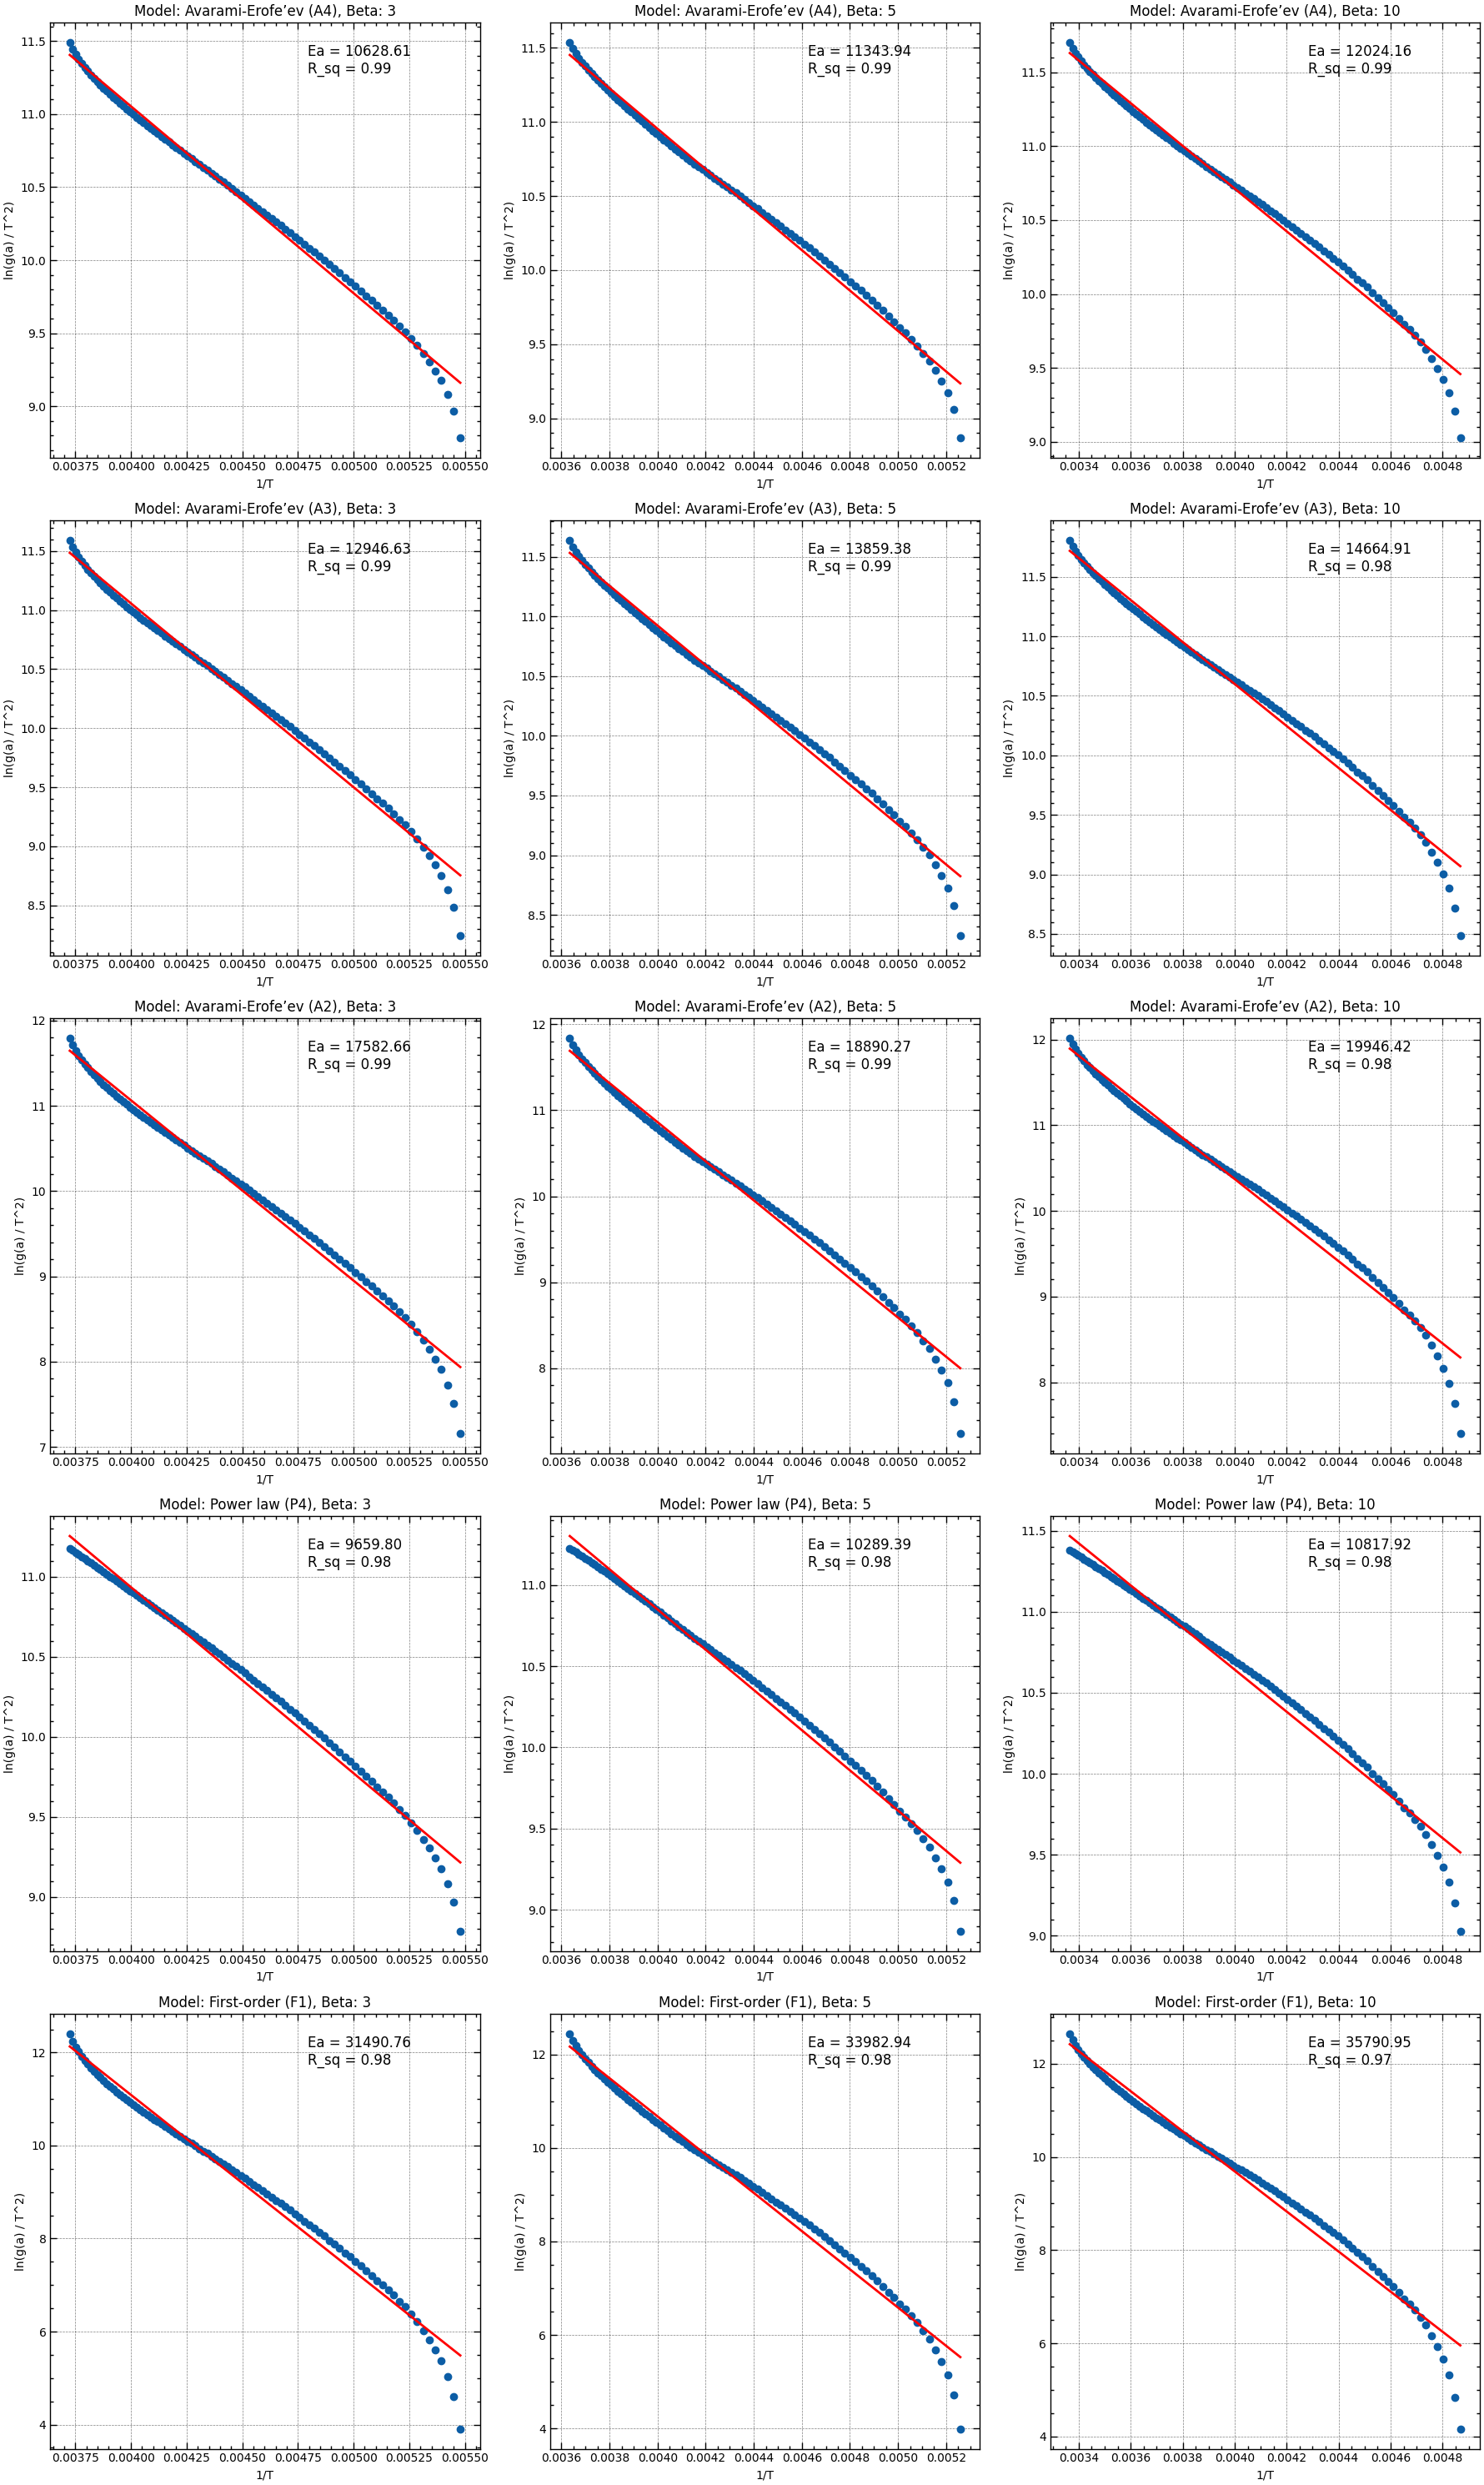

In [33]:
# На основе Coats-Redfern
def filter_data(lhs, temperature, x_val):
    mask = ~np.isnan(lhs) & ~np.isnan(temperature) & ~np.isnan(x_val)
    return temperature[mask], lhs[mask], x_val[mask]

# Устанавливаем число моделей для вывода на экран
NUM_MODELS = 5

fig, axs = plt.subplots(NUM_MODELS, len(heating_rates), figsize=(18, NUM_MODELS*6))  # NUM_MODELS строк, len(heating_rates) столбцов

for i in range(NUM_MODELS):
    for j, beta in enumerate(heating_rates):
        # Создаем фильтр для каждого beta
        beta_filter = coats_redfern['beta'] == beta
        # Применяем фильтр к DataFrame и сортируем его по 'R_sq'
        top_models = coats_redfern[beta_filter].sort_values('R_sq', ascending=False)
        
        if i < len(top_models):
            row = top_models.iloc[i]
            model = row['Equation']
            model_name = row['Model']
            
            temperature, conversion = get_data(df, beta)
            g_a_val = model_func(model, conversion)
            inverse_T = 1 / temperature
            lhs = calculate_coats_redfern_lhs(g_a_val, inverse_T)
            x_val = inverse_T
            temperature_clean, lhs_clean, x_val_clean = filter_data(lhs, temperature, x_val)

            # Строим график для каждой модели
            axs[i][j].plot(x_val_clean, lhs_clean, 'o')
            axs[i][j].set_title(f'Model: {model_name}, Beta: {beta}', fontsize=BIG_SIZE)
            axs[i][j].set_xlabel('1/T', fontsize=MEDIUM_SIZE)
            axs[i][j].set_ylabel('ln(g(a) / T^2)', fontsize=MEDIUM_SIZE)

            # Выполняем линейную регрессию и строим прямую линию
            slope, intercept, _, _, _ = perform_regression(x_val_clean, lhs_clean)
            axs[i][j].plot(x_val_clean, slope*x_val_clean + intercept, 'r-')

            # Выводим значения Ea, R_sq, R_corr, Spearman_corr, Kendall_corr на график
            Ea = row['Ea']
            r_sq = row['R_sq']                      
            axs[i][j].text(0.60, 0.95, f'Ea = {Ea:.2f}\nR_sq = {r_sq:.2f}', transform=axs[i][j].transAxes, fontsize=BIG_SIZE, verticalalignment='top')
            axs[i][j].tick_params(axis='both', which='both', labelsize=MEDIUM_SIZE)

plt.tight_layout()
plt.show()


$$ Безмодельные~методы $$
Как говорилось выше, уравнение 15 не имеет аналитического решения. По этой причине существует ряд интегральных изоконверсионных методов, которые отличаются аппроксимациями температурного интеграла $p(x)$. Многие из этих аппроксимаций приводят к линейным уравнениям общего вида:

$$\ln\left(\frac{{\alpha}_i}{T^B_i}\right) = \text{Const} - \frac{CE_a}{RT_a} \tag{21}$$

где B и C - параметры, определяемые типом аппроксимации температурного интеграла. Например, очень грубая аппроксимация Дойля, которая была выполнена для $x = 28–50$, где $x = \frac{Ea}{RT}$, дает B = 0 и C = 1.052, так что уравнение (21) принимает форму, также известную как уравнение Озавы, и/или Флинна и Уолла:

$$\ln({\alpha}_i) = \text{Const} - \frac{1.052E_a}{RT_a} \tag{22}$$

Грубая аппроксимация температурного интеграла приводит к неточным значениям $E_a$. Более точную аппроксимацию дают Мюррей и Уайт, они получают B = 2 и C = 1 и приводят к другому популярному уравнению, которое часто называют уравнением Киссинджера-Акахира-Суносе:

$$\ln\left(\frac{{\alpha}_i}{T^2_i}\right) = \text{Const} - \frac{E_a}{RT_a} \tag{23}$$

По сравнению с методом Озавы-Флинна-Уолла, метод Киссинджера-Акахира-Суносе предлагает значительное улучшение точности значений $E_a$. Как показал Старинк, несколько более точные оценки $E_a$ достигаются при установке B = 1.92 и C = 1.0008, так что уравнение (21) преобразуется в:

$$\ln\left(\frac{{\alpha}_i}{T^{1.92}_i}\right) = \text{Const} - \frac{1.0008E_a}{RT_a} \tag{24}$$

Поскольку вышеупомянутые уравнения (21) - (24) одинаково легко решить, применяя анализ линейной регрессии, рекомендуется использовать более точные уравнения, такие как (23) и (24).  Здесь следует настоятельно рекомендовать против часто встречающейся практики выполнения и отчетности по кинетическому анализу на основе одновременного использования более чем одной формы уравнения (21). Одновременное использование двух или более таких уравнений только раскрывает тривиальное различие в значениях $E_a$, вычисленных методами разной точности. Поскольку из такого сравнения не получается кинетическая информация, практику одновременного использования уравнений (21) - (24) следует исключить в пользу использования только одного более точного уравнения.


In [34]:
def mins_to_seconds(rate: str) -> int:
    """Преобразует минуты в секунды

    Args:
        rate (str): Строка, содержащая значение в минутах
    Returns:
        int: Преобразованное значение в секундах
    """
    return int(rate) / 60

def get_absolute_T(rate: str, conversion: float, reaction = 'reaction_0') -> np.float64:
    """Получает абсолютное значение температуры для заданной реакции в точке заданной конверсии

    Args:
        rate (str): Значение скорости нагрева
        conversion (float): Значение конверсии
        reaction (str, optional): Название реакции. По умолчанию 'reaction_0'.
    Returns:
        np.float64: Абсолютное значение температуры
    """
    return ((df[df[f'reactions_{rate}'] == reaction][f'conversion_{rate}'] - conversion)\
        .abs().idxmin() + 273.15)


def calculate_OFW_Ea(conversion: float, reaction: str) -> np.float64:
    """Вычисляет активационную энергию по уравнению Озавы-Флинна-Уолла

    Args:
        conversion (float): Значение конверсии
        reaction (str): Название реакции.
    Returns:
        np.float64: Значение активационной энергии
    """
    
    # Вычисляем лонарифм скорости нагрева в секундах
    betta = [np.log(mins_to_seconds(rate)) for rate in heating_rates]

    # Вычисляем значение 1000 / абсолютной температуры для графика
    log_T = [1000 / get_absolute_T(rate, conversion, reaction) for rate in heating_rates]

    # Вычисляем коэффициенты полинома первого порядка
    coefficient = np.polyfit(log_T, betta, 1)

    # Вычисляем активационную энергию
    Ea = coefficient[0] * R / -1.05
    
    return Ea

def calculate_KAS_Ea(conversion: float, reaction: str) -> np.float64:
    """Вычисляет активационную энергию по уравнению Киссенджера-Акахиры-Суносе

    Args:
        conversion (float): Значение преобразования
        reaction (str): Название реакции.
    Returns:
        np.float64: Значение активационной энергии
    """
    
    # Вычисляем лонарифм отношения скорости нагрева к квадрату абсолютной температуры
    betta = [np.log(mins_to_seconds(rate) / get_absolute_T(rate, conversion, reaction)**2) 
             for rate in heating_rates]
    
    # Вычисляем значение 1000 / абсолютной температуры для графика
    log_T = [1000 / get_absolute_T(rate, conversion, reaction) for rate in heating_rates]
    
    # Вычисляем коэффициенты полинома первого порядка
    coefficient = np.polyfit(log_T, betta, 1)
    
    # Вычисляем активационную энергию
    Ea = -coefficient[0] * R
    
    return Ea

def calculate_improved_Ea(conversion: float, reaction: str) -> np.float64:
    """Вычисляет активационную энергию по улучшенному уравнению.

    Args:
        conversion (float): Значение преобразования
        reaction (str): Название реакции.
    Returns:
        np.float64: Значение активационной энергии
    """
    
    # Вычисляем лонарифм отношения скорости нагрева к 1.92 степени абсолютной температуры
    betta = [np.log(mins_to_seconds(rate) / get_absolute_T(rate, conversion, reaction)**1.92) 
             for rate in heating_rates]
    
    # Вычисляем значение 1000 / абсолютной температуры для графика
    log_T = [1000 / get_absolute_T(rate, conversion, reaction) for rate in heating_rates]
    
    # Вычисляем коэффициенты полинома первого порядка
    coefficient = np.polyfit(log_T, betta, 1)
    
    # Вычисляем активационную энергию
    Ea = -coefficient[0] * R / 1.0008
    
    return Ea

In [35]:
# создаем пустой список для хранения данных
data = []

# Задаем кол-во точек в которых будет проводиться расчет Ea
VALUE_NUMBER = 25
conversion_values = np.linspace(0.01, 1, VALUE_NUMBER)

# для каждой реакции из списка all_reactions
for reaction in all_reactions:
    # для каждого значения конверсии
    for conversion in conversion_values:
        # вычисляем активационную энергию по различным методам
        Ea_KAS = calculate_KAS_Ea(conversion, reaction)
        Ea_OFW = calculate_OFW_Ea(conversion, reaction)
        Ea_improved = calculate_improved_Ea(conversion, reaction) 
        
        # добавляем результаты в список
        data.append({'reaction': reaction, 
                     'conversion': conversion,                     
                     'Ea_OFW': Ea_OFW,
                     'Ea_KAS': Ea_KAS,
                     'Ea_improved': Ea_improved}) 

# преобразуем список в DataFrame
Ea_df = pd.DataFrame(data)

# задаем имена столбцов
Ea_df.columns = ['reaction', 'conversion', 'Ea_OFW', 'Ea_KAS', 'Ea_improved']

Ea_df


,reaction,conversion,Ea_OFW,Ea_KAS,Ea_improved
0,reaction_0,0.01000,91.087998,87.789817,88.033493
1,reaction_0,0.05125,105.921706,103.144231,103.384466
2,reaction_0,0.09250,109.280568,106.543957,106.786553
3,reaction_0,0.13375,106.755817,103.788962,104.037918
4,reaction_0,0.17500,108.806216,105.862455,106.112928
...,...,...,...,...,...
70,reaction_2,0.83500,136.411980,132.049375,132.390790
71,reaction_2,0.87625,141.612866,137.484856,137.822944
72,reaction_2,0.91750,137.577808,133.225835,133.568215
73,reaction_2,0.95875,137.967456,133.619079,133.961779


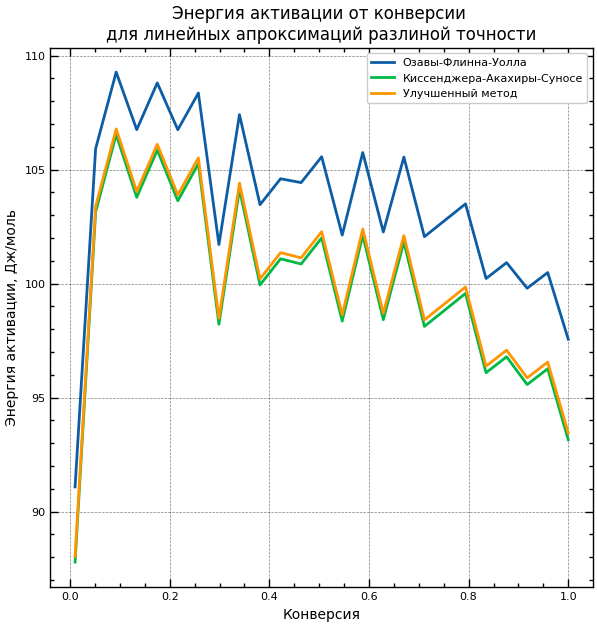

In [36]:
# фильтруем данные для reaction_0
reaction_0_data = Ea_df[Ea_df['reaction'] == 'reaction_0']

fig, ax = plt.subplots(figsize=(7,7))

# отрисовываем графики для всех трех методов
ax.plot(reaction_0_data['conversion'], reaction_0_data['Ea_OFW'], label='Озавы-Флинна-Уолла')
ax.plot(reaction_0_data['conversion'], reaction_0_data['Ea_KAS'], label='Киссенджера-Акахиры-Суносе')
ax.plot(reaction_0_data['conversion'], reaction_0_data['Ea_improved'], label='Улучшенный метод')

# устанавливаем подписи осей и название графика
ax.set_xlabel('Конверсия', fontsize=MEDIUM_SIZE)
ax.set_ylabel('Энергия активации, Дж/моль', fontsize=MEDIUM_SIZE)
ax.set_title('Энергия активации от конверсии \nдля линейных апроксимаций разлиной точности', fontsize=BIG_SIZE)
ax.tick_params(axis='both', which='both', labelsize=SMALL_SIZE)

# добавляем легенду
ax.legend(fontsize=SMALL_SIZE)

plt.show()


$$ Метод~Вязовкина $$ 
Интеграл по температуре $p(x)$ в неизотермическом законе скорости (уравнение 17) является функцией Ea и температуры. Поэтому уравнение 17 можно записать следующим образом:

$$g({\alpha}) = \frac{AEa}{\beta R} I(Ea,T) \tag{25}$$

где $I(Ea, T) = p(x)$. Общее предположение, используемое в методе Вязовкина (или любом другом изоконверсионном методе), состоит в том, что модель реакции не зависит от скорости нагрева (т. е. $g_{\alpha}$ будет одинаковой при любой скорости нагрева). Поэтому для значения превращения $(\alpha)$ можно определить следующее отношение, если применяются две скорости нагрева:

$$ g({\alpha}) = \frac{A_{\alpha} E_{a\alpha}}{\beta_1R} I(E_{a\alpha},T_{\alpha 1}) = \frac{A_{\alpha} E_{a\alpha}}{\beta_2 R} I(E_{a\alpha},T_{\alpha 2}) \tag{26} $$

где $\beta_1$ - первая скорость нагрева, $\beta_2$ - вторая скорость нагрева, $T_{\alpha 1}$ - температура для определенного значения $\alpha$ при использовании первой скорости нагрева, $T_{\alpha 2}$ - температура при том же значении $\alpha$ при использовании второй скорости нагрева, $E_{a\alpha}$ - энергия активации при этом значении $\alpha$ и $A_{\alpha}$ - частотный фактор при этом значении $\alpha$. Для эксперимента с "n" скоростями нагрева отношение будет следующим:

$$ g({\alpha}) = \frac{A_{\alpha} E_{a\alpha}}{\beta_1 R} I(E_{a\alpha},T_{\alpha 1}) = \frac{A_{\alpha} E_{a\alpha}}{\beta_2 R} I(E_{a\alpha},T_{\alpha 2}) = ... = \frac{E_{a\alpha}}{\beta_n R} I(E_{a\alpha},T_{\alpha n}) \tag{27}$$ 

что сводится к:

$$ \frac{I(E_{a\alpha}, T_{\alpha 1})}{\beta_1} = \frac{I(E_{a\alpha}, T_{\alpha 2})}{\beta_2} = ... = \frac{I(E_{a\alpha}, T_{\alpha n})}{\beta_n} = \sigma \tag{28} $$

где $\sigma$ - константа.

Для двух скоростей нагрева, используя два члена в уравнении 28, мы получаем:

$$ \frac{I(E_{a\alpha},T_{\alpha 1})}{\beta_1} = \frac{I(E_{a\alpha},T_{\alpha 2})}{\beta_2} = \sigma \tag{29} $$

Если обе стороны разделить на правый или левый член, мы получаем либо:

$$ \frac{\beta_2}{\beta_1}\frac{I(E_{a\alpha},T_{\alpha 1})}{I(E_{a\alpha},T_{\alpha 2})} = 1 \tag{30} $$ 

или

$$ \frac{\beta_1}{\beta_2}\frac{I(E_{a\alpha},T_{\alpha 2})}{I(E_{a\alpha},T_{\alpha 1})} = 1 \tag{31} $$

Объединение уравнения 30 и уравнения 31 дает:

$$ \frac{\beta_2}{\beta_1}\frac{I(E_{a\alpha},T_{\alpha 1})}{I(E_{a\alpha},T_{\alpha 2})} + \frac{\beta_1}{\beta_2}\frac{I(E_{a\alpha},T_{\alpha 2})}{I(E_{a\alpha},T_{\alpha 1})} = 2 \tag{32} $$

Для трех скоростей нагрева можно получить аналогичное уравнение, как показано ниже:

$$ \frac{\beta_2}{\beta_1}\frac{I(E_{a\alpha},T_{\alpha 1})}{I(E_{a\alpha},T_{\alpha 2})} + \frac{\beta_3}{\beta_1}\frac{I(E_{a\alpha},T_{\alpha 1})}{I(E_{a\alpha},T_{\alpha 3})} + \frac{\beta_1}{\beta_2}\frac{I(E_{a\alpha},T_{\alpha 2})}{I(E_{a\alpha},T_{\alpha 1})} + \frac{\beta_3}{\beta_2}\frac{I(E_{a\alpha},T_{\alpha 2})}{I(E_{a\alpha},T_{\alpha 3})} + \frac{\beta_1}{\beta_3}\frac{I(E_{a\alpha},T_{\alpha 3})}{I(E_{a\alpha},T_{\alpha 1})} + \frac{\beta_2}{\beta_3}\frac{I(E_{a\alpha},T_{\alpha 3})}{I(E_{a\alpha},T_{\alpha 2})} = 6 \tag{33} $$

Для "n" скоростей нагрева уравнения 32 и 33 можно обобщить как:

$$ \sum_{i=1}^{n} \sum_{j \neq i} \frac{\beta_jI(E_{a\alpha},T_{\alpha i})}{\beta_iI(E_{a\alpha},T_{\alpha j})} = n(n-1) \tag{34} $$

или

$$ n(n-1) \sum_{i=1}^{n} \sum_{j \neq i} \frac{\beta_jI(E_{a\alpha},T_{\alpha i})}{\beta_iI(E_{a\alpha},T_{\alpha j})} = 0 \tag{35} $$

где температурный интеграл:

$$
I(E_\alpha, T_\alpha) = \int_0^{T_a} \exp \left(-\frac{E_\alpha}{RT}\right) dT \tag{35}
$$

Этот интеграл решается численно. Минимизация повторяется для каждого значения $\alpha$, чтобы получить зависимость $Ea$ от $\alpha$. 

Все рассмотренные до сих пор интегральные изоконверсионные уравнения (21–24, 35) основаны на решении температурного интеграла при предположении, что значение $Ea$  остается постоянным на всем интервале интеграции, то есть $Ea$  не зависит от $\alpha$. На практике $Ea$  часто изменяется с $\alpha$. Нарушение предположения о постоянстве $Ea$  вносит систематическую ошибку в значение $Ea$. Ошибка может быть значительной, до 20–30% в случае сильных изменений $Ea$  с $\alpha$. Эта ошибка не возникает в дифференциальном методе и может быть устранена в интегральных методах путем интегрирования по малым сегментам температуры или времени. Такой тип интеграции легко вводится в уравнение (35) путем вычисления температурного интеграла как:

$$
I(E_\alpha, T_\alpha) = \int_{T_a - d\alpha}^{T_a} \exp \left(-\frac{E_\alpha}{RT}\right) dT \tag{36}
$$


In [37]:
# функция под интегралом
def integrand(T, Ea):
    return np.exp(-Ea/(R*T))

# функция для вычисления температурного интеграла
def I(Ea, T, dT):
    integral, _ = integrate.quad(integrand, T - dT, T, args=(Ea,))
    return integral

# Определяем функцию вычисления левой части уравнения Вязовкина с параметрами Ea (энергия активации), 
# dT (шаг изменения температуры при da=0.02) и произвольным числом других аргументов, в которые будем
# передавать попарно скорости нагрева и температуры при заданной конверсии для переданной скор. нагр.
def vyazovkin_lhs(Ea, dT, *args):
    # Проверяем, что количество дополнительных аргументов четное 
    # (так как они представляют собой пары температуры и скорости нагрева)
    assert len(args) % 2 == 0, "Неверное количество аргументов"
    
    # Вычисляем количество пар температура/скорость нагрева
    n = len(args) // 2 

    # Инициализируем переменную для накопления суммы отношений
    sum_ratio = 0
    
    # Перебираем все скорости нагрева
    for i in range(n):
        # Извлекаем температуру и скорость нагрева для текущего значения i        
        beta_i = args[i*2]  # i-тая скорость нагрева
        T_i = args[i*2+1]  # температура для i-той скорости нагрева
        
        # Перебираем все скорости нагрева еще раз
        for j in range(n):
            # Если i не равно j (так как мы не должны сравнивать скорость нагрева с самой собой)
            if j != i:
                # Извлекаем температуру и скорость нагрева для текущего значения j
                beta_j = args[j*2]  # j-тая скорость нагрева
                T_j = args[j*2+1]  # температура для j-той скорости нагрева                
                
                # Вычисляем отношение для текущей пары i и j и добавляем его к накопленной сумме
                sum_ratio += beta_j/beta_i * I(Ea, T_i, dT)/I(Ea, T_j, dT)

    # Вычисляем и возвращаем результат, вычитая накопленную сумму отношений из n*(n-1)
    result = n*(n-1) - sum_ratio 
    return result

def get_b_T_couples_list(conv, df, heating_rates, da=0.02):
    # Создаем пустые списки, где будут храниться результаты
    results = []
    dT = []
    
    # Проходим по каждой скорости нагрева из списка heating_rates
    for rate in heating_rates:
        
        # Создаем новые DataFrame 'filtered_df' и 'filtered_df_lower', 
        # которые содержат только те строки из исходного df,
        # где значение в столбце 'reactions_{rate}' равно 'reaction_0'.        
        filtered_df = df[df[f'reactions_{rate}'] == 'reaction_0'].copy()
        filtered_df_lower = df[df[f'reactions_{rate}'] == 'reaction_0'].copy()

        # В новом столбце 'diff' вычисляем абсолютную разницу между каждым значением 
        # в столбце 'conversion_{rate}' и заданным 'conv'.        
        filtered_df.loc[:, 'diff'] = abs(filtered_df[f'conversion_{rate}'] - conv)
        filtered_df_lower.loc[:, 'diff'] = abs(filtered_df_lower[f'conversion_{rate}'] - (conv - da))

        # Ищем температуру (индекс в filtered_df и filtered_df_lower), 
        # при которой разница 'diff' минимальна.
        temp = filtered_df['diff'].idxmin()
        temp_lower = filtered_df_lower['diff'].idxmin()

        # Добавляем скорость нагрева и температуру в результаты
        results.append(int(rate))
        results.append(temp+273.15) # Переводим температуру в Кельвины

        # Добавляем разницу температур в список dT
        dT.append(temp - temp_lower)

    # Возвращаем dT и результаты
    return np.mean(dT), results

In [38]:
# Задаем диапазон конверсии и энергии активации
conversion = np.round(np.arange(0.01, 1, 0.01),4)
Ea = np.arange(15000, 150001, 1000)

# Создаем пустой датафрейм для хранения результатов
vyazovkin_df = pd.DataFrame(index=Ea, columns=conversion)

# Для каждого значения энергии активации и конверсии
for E in tqdm(Ea, position=0, leave=True):
    for conv in conversion:
        # Вычисляем среднее значение dT и пары скорости нагрева / температуры
        dT, beta_T_couples = get_b_T_couples_list(conv, df, heating_rates)
        
        # Вычисляем значение функции vyazovkin_lhs и сохраняем его в датафрейме
        vyazovkin_df.loc[E, conv] = vyazovkin_lhs(E, dT, *beta_T_couples)

for col in vyazovkin_df.columns:
    vyazovkin_df[col] = pd.to_numeric(vyazovkin_df[col], errors='coerce')

  0%|          | 0/136 [00:00<?, ?it/s]

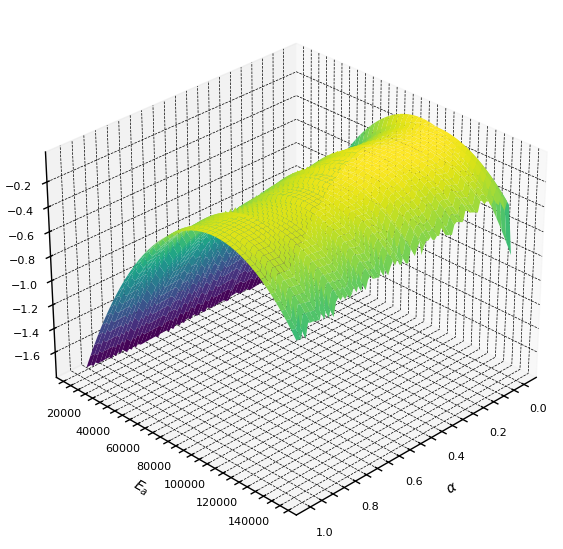

In [39]:
# Создаем объекты для осей x и y
x = vyazovkin_df.columns.values
y = vyazovkin_df.index.values

# Создаем двумерный массив z значений, с использованием значений в DataFrame
z = vyazovkin_df.values

# Создаем сетку координат из x и y
X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Отрисовываем поверхность
surf = ax.plot_surface(X, Y, z, cmap='viridis')

# Устанавливаем названия осей с изменяемым размером
ax.set_xlabel(r'$\alpha$', fontsize=MEDIUM_SIZE)
ax.set_ylabel(r'$E_a$', fontsize=MEDIUM_SIZE)
ax.set_zlabel(r'$\sigma$', fontsize=MEDIUM_SIZE)

# Изменяем размер подписей сетки осей
ax.tick_params(axis='x', labelsize=SMALL_SIZE)
ax.tick_params(axis='y', labelsize=SMALL_SIZE)
ax.tick_params(axis='z', labelsize=SMALL_SIZE)

# Поворачиваем фигуру по часовой стрелке на azim градусов
ax.view_init(elev=None, azim=45)

# Сохраняем рисунок
plt.savefig('vyazovkin.png')

# Выводим график
plt.show()


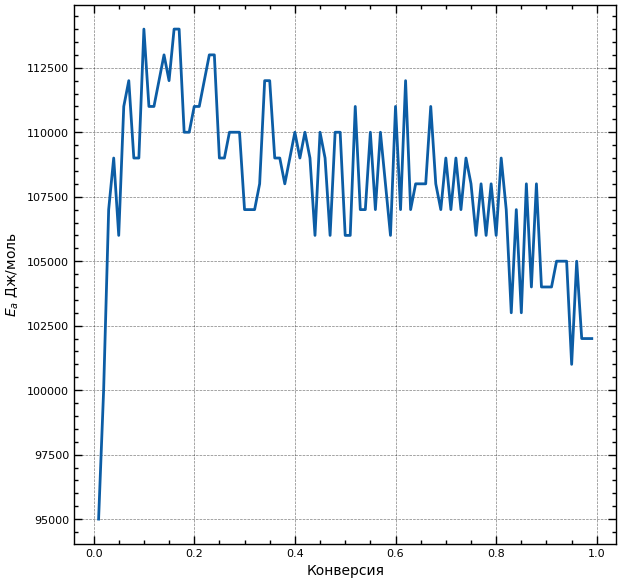

In [40]:
closest_to_zero = vyazovkin_df.abs().min()
vyazovkin_Ea = vyazovkin_df.abs().idxmin()

fig, ax = plt.subplots(figsize=(7,7))
ax.plot(vyazovkin_Ea.index, vyazovkin_Ea.values)
ax.set_xlabel('Конверсия', fontsize=MEDIUM_SIZE)
ax.set_ylabel(r'$E_a$'+' Дж/моль', fontsize=MEDIUM_SIZE)
#ax.set_title('Энергия активации от конверсии, расчитанная по методу Вязовкина', fontsize=BIG_SIZE)
ax.tick_params(axis='both', which='both', labelsize=SMALL_SIZE)
plt.show()

$$ y(\alpha)~и~z(\alpha)~мастер~графики $$
После нахождения $Ea$ безмодельным методом, необходимо убедиться, что она не меняется значительно в зависимости от $\alpha$. Затем приближенно постоянное значение $Ea$ можно заменить средним значением $E_0$, которое подставляется в уравнения (37) или (39). Функция $y(\alpha)$ имеет следующую форму:

$$ y(\alpha) = \frac{d\alpha}{dt}_a \exp\left(\frac{E_0}{RT_\alpha}\right) = Af(\alpha) \tag{37} $$

Уравнение (37) легко получается путем перестановки уравнения дифференциальной формы неизотермического закона скорости реакции (9). Значения $y(\alpha)$ определяются непосредственно из экспериментальных данных путем подстановки $E_0$ в уравнение (37). Затем для каждого значения $\alpha$ необходимо определить экспериментальные значения $(d\alpha/dt)_a$ и $T_\alpha$, связанные с этим $\alpha$, и вставить их в уравнение (37). Полученные в результате экспериментальные значения $y(\alpha)$ строятся в виде функции от $\alpha$ и сравниваются с теоретическими мастер графиками $y(\alpha)$. Подходящая модель определяется как наилучшее соответствие между экспериментальными и теоретическими главными графиками $y(\alpha)$.

Как видно из уравнения (37), форма теоретических мастер графиков $y(\alpha)$ полностью определяется формой функций $f(\alpha)$, поскольку $A$ является постоянной. Однако, поскольку предэкспоненциальный фактор еще не известен, экспериментальные и теоретические графики $y(\alpha)$ должны быть нормализованы. По практическим причинам графики $y(\alpha)$ нормализуются так, чтобы они варьировались от 0 до 1. Тип модели реакции можно распознать по форме экспериментального графика $y(\alpha)$.

Мастер график $z(\alpha)$ получаются путем объединения дифференциальной и интегральной форм моделей реакции. Интеграл температуры в уравнении (15) может быть заменен на различные приближения, $\pi(x)$ следующим образом:

$$g(a) = \frac{AE}{\beta R}\exp(-x)\pi(x)/x \tag{38}$$

где $x = E/RT$. Комбинирование уравнений (9) и (38), за которым следует некоторая перестановка, позволяет ввести функцию $z(\alpha)$ в виде:

$$z(\alpha) = f(\alpha)g(\alpha) = \frac{da}{dt}_a T^2_\alpha \frac{\pi(x)}{\beta T_\alpha} \tag{39}$$

Установлено, что член дроби уравнения (39) оказывает пренебрежимое влияние на форму функции $z(\alpha)$. Таким образом, значения $z(\alpha)$ можно определить для каждого значения $\alpha$, умножив экспериментальные значения $da/dt_a$ и $T^2_a$. Полученные в результате экспериментальные значения $z(\alpha)$ строятся в виде функции от $\alpha$ и сравниваются с теоретическими мастер графиками $z(\alpha)$. Подходящая модель определяется как наилучшее соответствие между экспериментальными и теоретическими мастер графиками $z(\alpha)$. Из серии экспериментальных кинетических кривых, измеренных при различных $\beta$, можно получить серию экспериментальных графиков $z(\alpha)$, которые, однако, должны давать единственную зависимость $z(\alpha)$ от $\alpha$, практически независимую от $\beta$. Теоретические графики $z(\alpha)$ получаются путем построения произведения $f(\alpha)g(\alpha)$ против $\alpha$ для различных моделей реакции.

Следует отметить, что графики $z(\alpha)$ демонстрируют максимум при определенном значении конверсии, $a_p$, который может быть найден из условия:

$$g(\alpha)f'(\alpha) = -1 \tag{40}$$

Значения $a_p$ были рассчитаны для ряда моделей реакции. Значения могут оказать некоторую дополнительную помощь при определении подходящих моделей реакции для экспериментальных данных. Как только модель реакции была идентифицирована, предэкспоненциальный фактор определяется из следующего уравнения:

$$ A =  \frac{-\beta E_0}{R T^2_{max} f'(a_{max})}\exp\left(\frac{E_0}{RT_{max}}\right) \tag{41} $$

В уравнении (41) индекс $max$ обозначает значения, связанные с максимумом дифференциальной кинетической кривой, полученной при данной скорости нагрева.

Проблема с моделью Zero-order (F0/R1): x and y must have same first dimension, but have shapes (500,) and (1,)


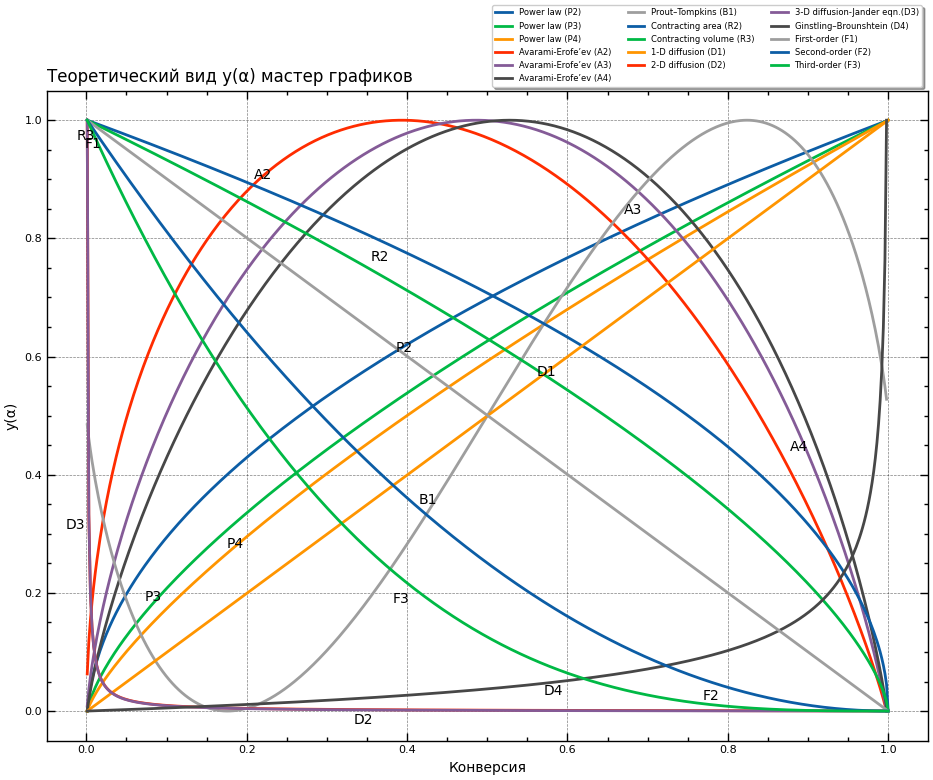

In [72]:
# Создаем значения a от 0 до 1
a = np.linspace(0.001, 1, 500)  # Значения начинаются с 0.001, чтобы избежать деления на ноль

fig, ax = plt.subplots(figsize=(10, 8))

# DataFrame для хранения результата
ya_curves_df = pd.DataFrame()

# Цикл по всем моделям
for index, row in models_df.iterrows():
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            
            y = eval(row['Differential Form'])  # использование eval для интерпретации выражения как кода Python
            
            # Если максимальное значение бесконечно или np.nan, заменяем его на максимальное не-бесконечное и не-nan значение
            if np.isinf(np.max(y)) or np.isnan(np.max(y)):
                y_max = np.nanmax(y[~np.isinf(y) & ~np.isnan(y)])
            else:
                y_max = np.max(y)
                
            # Если минимальное значение бесконечно или np.nan, заменяем его на минимальное не-бесконечное и не-nan значение
            if np.isinf(np.min(y)) or np.isnan(np.min(y)):
                y_min = np.nanmin(y[~np.isinf(y) & ~np.isnan(y)])
            else:
                y_min = np.min(y)           
            
            y_norm = (y - y_min)/(y_max - y_min)  # нормализация данных
            
            ax.plot(a, y_norm, label=row['Model'])
            
            # Находим сокращенное название модели и добавляем его на график
            short_name = re.search(r'\((.*?)\)', row['Model']).group(1)
            rand_index = np.random.choice(range(len(a)))  # выбираем случайную точку для аннотации
            ax.annotate(short_name, (a[rand_index], y_norm[rand_index]), textcoords="offset points", xytext=(-10,-10), ha='center')

            # Добавляем данные в DataFrame
            temp_df = pd.DataFrame({
                'Conversion': a,
                'Normalized Differential Form': y_norm,
                'Model': row['Model']
            })
            ya_curves_df = pd.concat([ya_curves_df, temp_df])
            
    except Exception as e:
        print(f"Проблема с моделью {row['Model']}: {str(e)}")

# Настройка легенды
ax.legend(loc='best', bbox_to_anchor=(0.5, 1.00), ncol=3, fancybox=True, shadow=True, prop={'size': 6})

ax.set_xlabel('Конверсия', fontsize=MEDIUM_SIZE)
ax.set_ylabel('y(α)', fontsize=MEDIUM_SIZE)
ax.set_title('Теоретический вид y(α) мастер графиков', fontsize=BIG_SIZE, loc='left')
ax.tick_params(axis='both', which='major', labelsize=SMALL_SIZE)

plt.tight_layout()
plt.show()


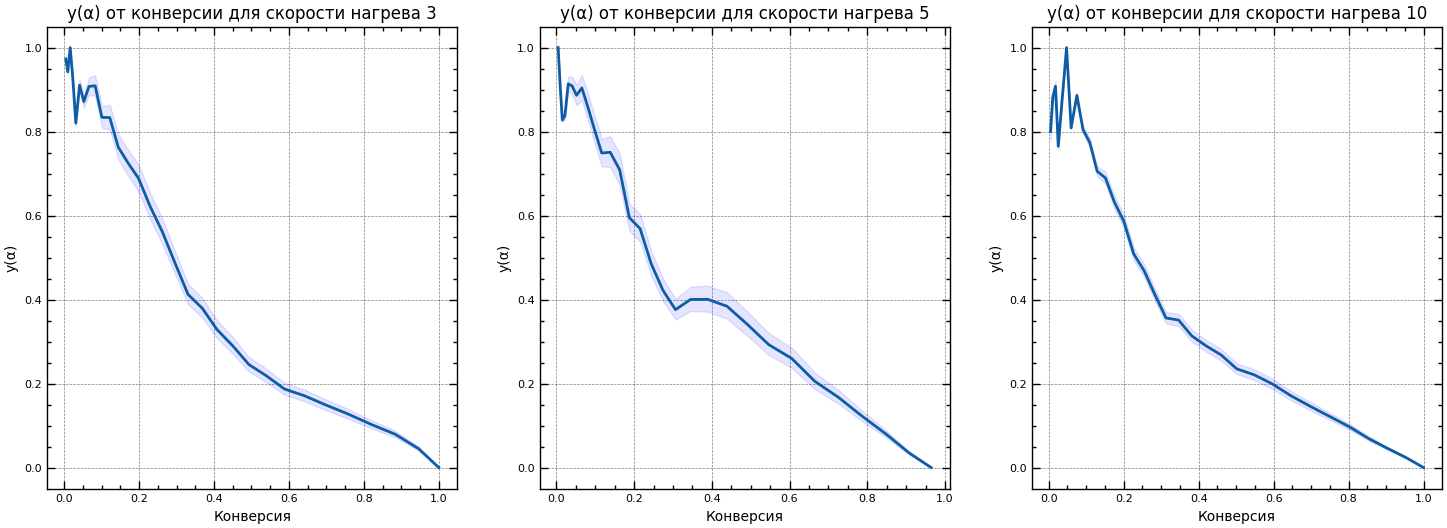

In [42]:
# Создаём пустой словарь для хранения значений конверсии
conversion_values = {}

# Перебираем скорости нагрева
for rate in heating_rates:
    # Для каждой скорости нагрева вычисляем значения конверсии для reaction_0 и добавляем их в словарь
    conversion_values[rate] = df[df[f'reactions_{rate}'] == 'reaction_0'][f'conversion_{rate}']

# Задаем размер шага для фильтрации значений
STEP_SIZE = 3

# Создаём пустой словарь для хранения отфильтрованных значений конверсии
filtered_conversion_values = {}

# Перебираем скорости нагрева и их соответствующие значения конверсии
for key, values in conversion_values.items():
    # Фильтруем значения конверсии с заданным размером шага и добавляем их в словарь
    filtered_values = values[::STEP_SIZE]
    filtered_conversion_values[key] = filtered_values

# Получаем описательную статистику для E0, исключая первые и последние 4 значения
E0_stats = vyazovkin_Ea.iloc[4:-4].describe()
E0_mean = E0_stats['mean']
E0_std = E0_stats['std']

# Создаём пустые словари для хранения нормализованных значений y(α) и его доверительных интервалов
y_alpha = {}
y_alpha_lower = {}
y_alpha_upper = {}

# Перебираем скорости нагрева
for rate in heating_rates:
    # Извлекаем отфильтрованные значения конверсии для данной скорости нагрева
    conversion_rate = filtered_conversion_values[rate]
    # Переводим индексы температуры из градусов Цельсия в Кельвины
    T_alpha = conversion_rate.index + 273.15
    # Вычисляем скорость изменения конверсии
    d_alpha_dt = conversion_rate.diff()/ conversion_rate.index.to_series().diff()
    
    # Вычисляем экспоненциальные члены в уравнении для нижней и верхней границ доверительных интервалов
    exp_term_lower = np.exp((E0_mean - E0_std) / (R * T_alpha))
    exp_term_upper = np.exp((E0_mean + E0_std) / (R * T_alpha))
    
    # Вычисляем y(α) для нижней и верхней границ доверительных интервалов и удаляем значения NaN
    y_a_lower = (d_alpha_dt * exp_term_lower).dropna()
    y_a_upper = (d_alpha_dt * exp_term_upper).dropna()

    # Вычисляем экспоненциальный член в уравнении для среднего значения E0
    exp_term = np.exp(E0_mean / (R * T_alpha))

    # Вычисляем y(α) и удаляем значения NaN
    y_a = (d_alpha_dt * exp_term).dropna()

    # Выполняем нормализацию y(α) и его доверительных интервалов
    y_a_norm = (y_a - y_a.min()) / (y_a.max() - y_a.min())
    y_a_lower_norm = (y_a_lower - y_a_lower.min()) / (y_a_lower.max() - y_a_lower.min())
    y_a_upper_norm = (y_a_upper - y_a_upper.min()) / (y_a_upper.max() - y_a_upper.min())

    # Добавляем нормализованные значения y(α) и его доверительных интервалов в словари
    y_alpha[rate] = y_a_norm
    y_alpha_lower[rate] = y_a_lower_norm
    y_alpha_upper[rate] = y_a_upper_norm    

# Создаём новую фигуру для графиков
fig, axs = plt.subplots(1, len(heating_rates), figsize=(6*len(heating_rates), 6))

# Перебираем скорости нагрева
for i, rate in enumerate(heating_rates):
    ax = axs[i]
    # Строим график y(α) для данной скорости нагрева
    ax.plot(filtered_conversion_values[rate].values[1:], y_alpha[rate], label=f'Heating rate: {rate}')
    # Добавляем доверительный интервал на график
    ax.fill_between(filtered_conversion_values[rate].values[1:], y_alpha_lower[rate], y_alpha_upper[rate], color='b', alpha=.1)

    # Устанавливаем название для оси X
    ax.set_xlabel('Конверсия', fontsize=MEDIUM_SIZE)
    # Устанавливаем название для оси Y
    ax.set_ylabel('y(α)', fontsize=MEDIUM_SIZE)
    # Устанавливаем заголовок графика
    ax.set_title(f'y(α) от конверсии для скорости нагрева {rate}', fontsize=BIG_SIZE)
    # Устанавливаем размер шрифта для делений на осях
    ax.tick_params(axis='both', which='both', labelsize=SMALL_SIZE)

# Отображаем график
plt.show()


In [71]:
# Создаем DataFrame для хранения нормализованных значений кривых
normalized_curves_df = pd.DataFrame()

# Создаем DataFrame для хранения значений среднеквадратического отклонения (MSE)
mse_df = pd.DataFrame()

# Цикл для перебора всех ключей в словаре filtered_conversion_values
for key in filtered_conversion_values.keys():
    # Присваиваем переменной a значения по ключу key, начиная со второго элемента
    a = filtered_conversion_values[key].values[1:]

    # Вложенный цикл для перебора всех моделей в DataFrame models_df
    for index, row in models_df.iterrows():
        # Обработка исключений для обнаружения ошибок во время выполнения кода
        try:
            # Игнорирование предупреждений
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")

                # Использование eval для выполнения выражения Python, хранящегося в столбце 'Differential Form' как кода
                y = eval(row['Differential Form'])

                # Если максимальное значение y бесконечно или NaN, заменяем его на максимальное не-бесконечное и не-NaN значение
                if np.isinf(np.max(y)) or np.isnan(np.max(y)):
                    y_max = np.nanmax(y[~np.isinf(y) & ~np.isnan(y)])
                else:
                    y_max = np.max(y)

                # Если минимальное значение y бесконечно или NaN, заменяем его на минимальное не-бесконечное и не-NaN значение
                if np.isinf(np.min(y)) or np.isnan(np.min(y)):
                    y_min = np.nanmin(y[~np.isinf(y) & ~np.isnan(y)])
                else:
                    y_min = np.min(y)

                # Нормализация значений y
                y_norm = (y - y_min)/(y_max - y_min)

                # Создаем временный DataFrame и добавляем его в итоговый DataFrame
                temp_df = pd.DataFrame({
                    'conversion': a,
                    'normalized_differential_form': y_norm,
                    'model': row['Model'],
                    'heating_rate': key,
                })

                # Добавляем временный DataFrame в итоговый DataFrame
                normalized_curves_df = pd.concat([normalized_curves_df, temp_df])

        # Обработка исключений и вывод информации об ошибке
        except Exception as e:
            print(f"Проблема с моделью {row['Model']}: {str(e)}")

# Получаем список уникальных моделей
model_names = models_df['Model'].unique()

# Создаем DataFrame для хранения значений MSE с именами скоростей нагрева как столбцы и моделями как индекс
mse_df = pd.DataFrame(columns=heating_rates, index=model_names)

# Цикл для расчета MSE каждой модели
for model in model_names:
    for rate in heating_rates:
        # Выбираем подходящие данные из normalized_curves_df
        data = normalized_curves_df[
            (normalized_curves_df['model'] == model)
            &(normalized_curves_df['heating_rate'] == rate)]['normalized_differential_form']

        # Получаем индексы, где значения в data являются конечными
        finite_indices = np.isfinite(data)

        # Используем эти индексы для отбора значений в data и y_alpha
        filtered_data = data[finite_indices]
        filtered_y_alpha = y_alpha[rate].values[finite_indices]

        # Рассчитываем MSE между отфильтрованными значениями
        mse = np.mean((filtered_data - filtered_y_alpha)**2)

        # Сохраняем MSE в DataFrame
        mse_df.loc[model, rate] = mse

# Выводим DataFrame с MSE
mse_df

,3,5,10
Power law (P2),0.402981,0.372265,0.367765
Power law (P3),0.417455,0.388295,0.374723
Power law (P4),0.423931,0.39563,0.37805
Avarami-Erofe’ev (A2),0.294949,0.261316,0.278103
Avarami-Erofe’ev (A3),0.353936,0.314218,0.327884
Avarami-Erofe’ev (A4),0.377853,0.335956,0.347373
Prout–Tompkins (B1),0.396261,0.372918,0.36147
Contracting area (R2),0.081925,0.055361,0.106602
Contracting volume (R3),0.054482,0.041967,0.075405
1-D diffusion (D1),0.439402,0.413736,0.38618


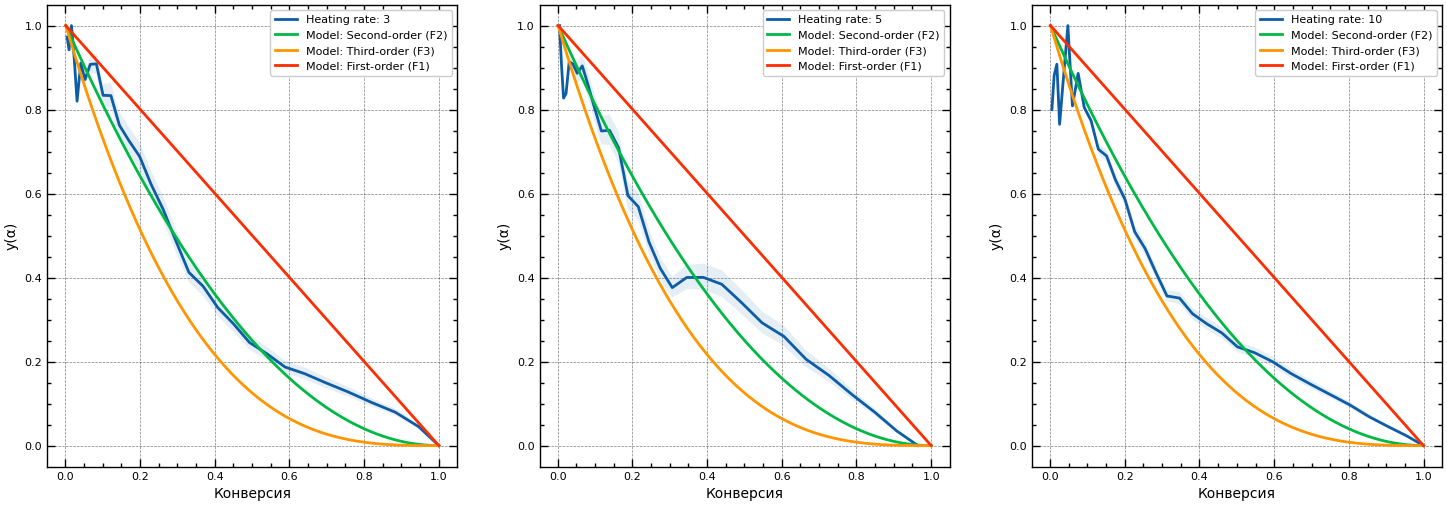

In [87]:
TOP_N = 3

# Создаём новую фигуру для графиков
fig, axs = plt.subplots(1, len(heating_rates), figsize=(6*len(heating_rates), 6))

# Перебираем скорости нагрева
for i, rate in enumerate(heating_rates):
    ax = axs[i]

    # Строим график y(α) для данной скорости нагрева и добавляем доверительный интервал
    ax.plot(filtered_conversion_values[rate].values[1:], y_alpha[rate], label=f'Heating rate: {rate}')
    ax.fill_between(filtered_conversion_values[rate].values[1:], y_alpha_lower[rate], y_alpha_upper[rate], alpha=.1)

    # Сортируем mse для данной скорости нагрева и выбираем топ модели
    top_models = mse_df[rate].sort_values().head(TOP_N).index

    # Для каждой модели в топе отбираем данные из ya_curves_df и строим график
    for model in top_models:
        model_data = ya_curves_df[ya_curves_df['Model'] == model]
        ax.plot(model_data['Conversion'], model_data['Normalized Differential Form'], label=f'Model: {model}')

    ax.set_xlabel('Конверсия', fontsize=MEDIUM_SIZE)
    ax.set_ylabel('y(α)', fontsize=MEDIUM_SIZE)
    #ax.set_title(f'... {rate}', fontsize=BIG_SIZE)
    ax.tick_params(axis='both', which='both', labelsize=SMALL_SIZE)
    # добавляем легенду
    ax.legend(fontsize=SMALL_SIZE)

plt.show()



In [90]:
mse_df

,3,5,10
Power law (P2),0.402981,0.372265,0.367765
Power law (P3),0.417455,0.388295,0.374723
Power law (P4),0.423931,0.39563,0.37805
Avarami-Erofe’ev (A2),0.294949,0.261316,0.278103
Avarami-Erofe’ev (A3),0.353936,0.314218,0.327884
Avarami-Erofe’ev (A4),0.377853,0.335956,0.347373
Prout–Tompkins (B1),0.396261,0.372918,0.36147
Contracting area (R2),0.081925,0.055361,0.106602
Contracting volume (R3),0.054482,0.041967,0.075405
1-D diffusion (D1),0.439402,0.413736,0.38618


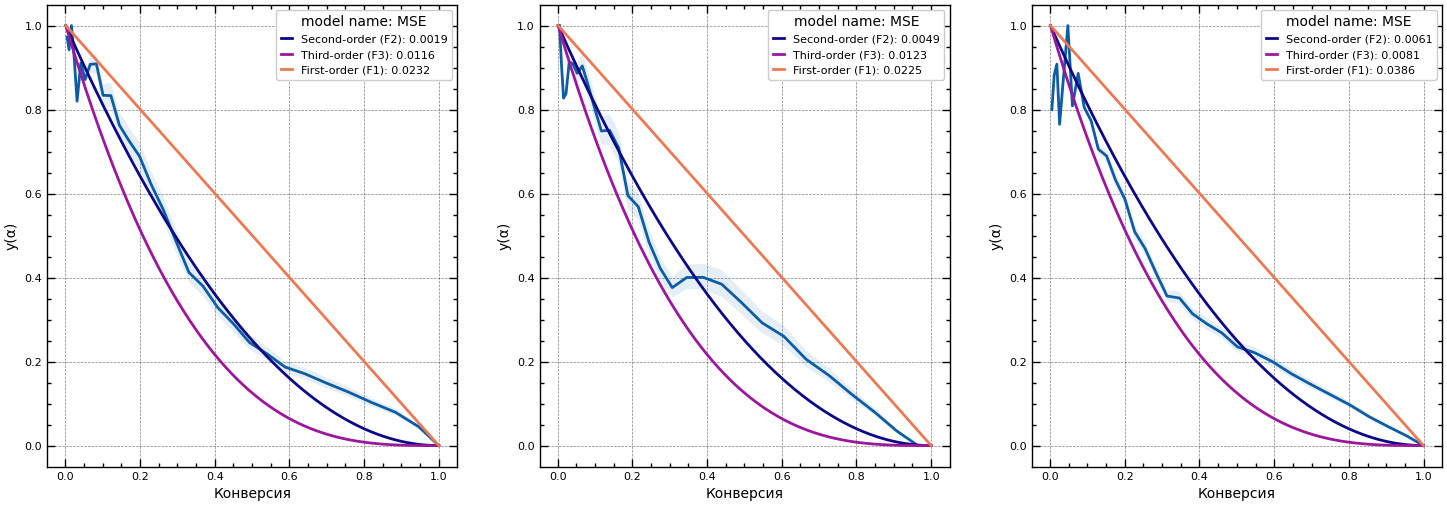

In [99]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

TOP_N = 3

# Создаём новую фигуру для графиков
fig, axs = plt.subplots(1, len(heating_rates), figsize=(6*len(heating_rates), 6))

# Получаем цветовую палитру
palette = plt.cm.plasma

# Перебираем скорости нагрева
for i, rate in enumerate(heating_rates):
    ax = axs[i]

    # Строим график y(α) для данной скорости нагрева и добавляем доверительный интервал
    ax.plot(filtered_conversion_values[rate].values[1:], y_alpha[rate], label=f'Heating rate: {rate}')
    ax.fill_between(filtered_conversion_values[rate].values[1:], y_alpha_lower[rate], y_alpha_upper[rate], alpha=.1)

    # Сортируем mse для данной скорости нагрева и выбираем топ модели
    top_models = mse_df[rate].sort_values().head(TOP_N).index

    # Создаём пустой список для хранения пар "название модели - mse"
    mse_values = []

    # Для каждой модели в топе отбираем данные из ya_curves_df и строим график
    for j, model in enumerate(top_models):
        model_data = ya_curves_df[ya_curves_df['Model'] == model]
        ax.plot(model_data['Conversion'], model_data['Normalized Differential Form'], color=palette(j / TOP_N))

        # Вычисляем mse для модели, округляем до 4 знаков и добавляем в список
        mse_value = round(mse_df.loc[model, rate], 4)
        mse_values.append((palette(j / TOP_N), model, mse_value))

    ax.set_xlabel('Конверсия', fontsize=MEDIUM_SIZE)
    ax.set_ylabel('y(α)', fontsize=MEDIUM_SIZE)
    ax.tick_params(axis='both', which='both', labelsize=SMALL_SIZE)

    # Создаём DataFrame для таблицы в легенде
    mse_df_for_legend = pd.DataFrame(mse_values, columns=['Color', 'Model', 'MSE'])
    mse_df_for_legend.set_index(['Color', 'Model'], inplace=True)

    # Добавляем легенду с таблицей
    legend_labels = [plt.Line2D([0], [0], color=c, lw=2) for c in mse_df_for_legend.index.get_level_values('Color')]
    ax.legend(
        legend_labels, 
        [f'{m}: {v}' for m, v in zip(mse_df_for_legend.index.get_level_values('Model'), mse_df_for_legend['MSE'])], 
        title='model name: MSE', title_fontsize=MEDIUM_SIZE, handlelength=1, fontsize=SMALL_SIZE)

plt.show()
